In [1]:
import numpy as np
import re
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import warnings

    
## Herramientas para contar tiempo
import time

pd.options.mode.chained_assignment = None  # default='warn'

pd.set_option('display.max_columns', None)

In [2]:
train_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/train.csv",dtype={'StateHoliday': object})
test_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/test.csv")
store_df = pd.read_csv("https://raw.githubusercontent.com/alessiobocco/MiM/main/Machine%20learning/data/store.csv")

In [3]:
def RMSPE(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))

    return loss

### Archivos:
* **train.csv** - datos histórico incluyendo Sales
* **test.csv** - datos histórico excluyendo Sales
* **sample_submission.csv** - ejemplo del formato que debe tener el submission a Kaggle 
* **store.csv** - información suplementaria sobre las tiendas

### Campos:
Descripción de los campos menos descriptivos

* **Id** - Id único para cada par de Store y Date
* **Store** - Id unívoco para cada tienda
* **Sales** - ventas para cada día dado. Variable target
* **Customers** - cantidad de clientes para un día dado
* **Open** - variable binaria que indica si la tienda esta abierta o no: 0 = cerrada, 1 = abierta
* **StateHoliday** - indica si se trata de un feriado estatal. Normalmente las tienfas estan cerradas durante los feriados: a = feriado, b = Pascuas, c = Navidad, 0 = ninguna. 
* **SchoolHoliday** - indica si la dupla Tienda, fecha es afectada por el cierre de las esceulas. 
* **StoreType** - diferentes modelos de tiendas: a, b, c, d
* **Assortment** - grado de provisionamiento: a = basic, b = extra, c = extended
* **CompetitionDistance** - distancia en metros a la tienda del competidor mas cercano. 
* **CompetitionOpenSince**[Month/Year] - año y mes en que abrió el competidor más cercano.
* **Promo** - indica si la tienda tiene una promoción ese día o no.
* **Promo2** - Promo2 indica si la tienda esta participa de promociones consecutivas: 0 = la tienda no participa, 1 = tienda participa
* **Promo2Since**[Year/Week] - indica la semana y año en la que la tienda comenzó a participar de Promo2
* **PromoInterval** - meses en los que comienza Promo2. Por ejemplo: "Feb,May,Aug,Nov" significa que la ronda de promociones comienza en Febrero, Mayo, Agosto y Noviembre. 

In [4]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [8]:
train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [9]:
store_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


### Combinacion de ambos datasets

In [10]:
train_df = train_df.merge(store_df, how='left', on='Store') 
test_df = test_df.merge(store_df, how='left', on='Store') 

In [11]:
ID = test_df['Id']
test_df.drop('Id',inplace=True,axis=1)

train_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)
test_df.sort_values(["Store","Date"], ignore_index=True, inplace=True)

for dataset in (train_df,test_df):
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset['Day'] = dataset.Date.dt.day
    dataset['Month'] = dataset.Date.dt.month
    dataset['Year'] = dataset.Date.dt.year
    dataset['DayOfYear'] = dataset.Date.dt.isocalendar().week
    dataset['WeekOfYear'] = dataset.Date.dt.isocalendar().week
    dataset.set_index('Date', inplace=True)

In [12]:
import calendar

def get_day_of_week(day_number):
    # Los días de la semana en el módulo de calendario están indexados comenzando en 0 (0 es lunes)
    day_name = calendar.day_name[int(day_number) - 1]
    return day_name

In [13]:
# Creas una nueva columna 'DayName' aplicando la función a la columna 'DayNumber'
train_df['DayName'] = train_df['DayOfWeek'].apply(get_day_of_week)
test_df['DayName'] = test_df['DayOfWeek'].apply(get_day_of_week)

# Análisis exploratorio

### Variables numéricas

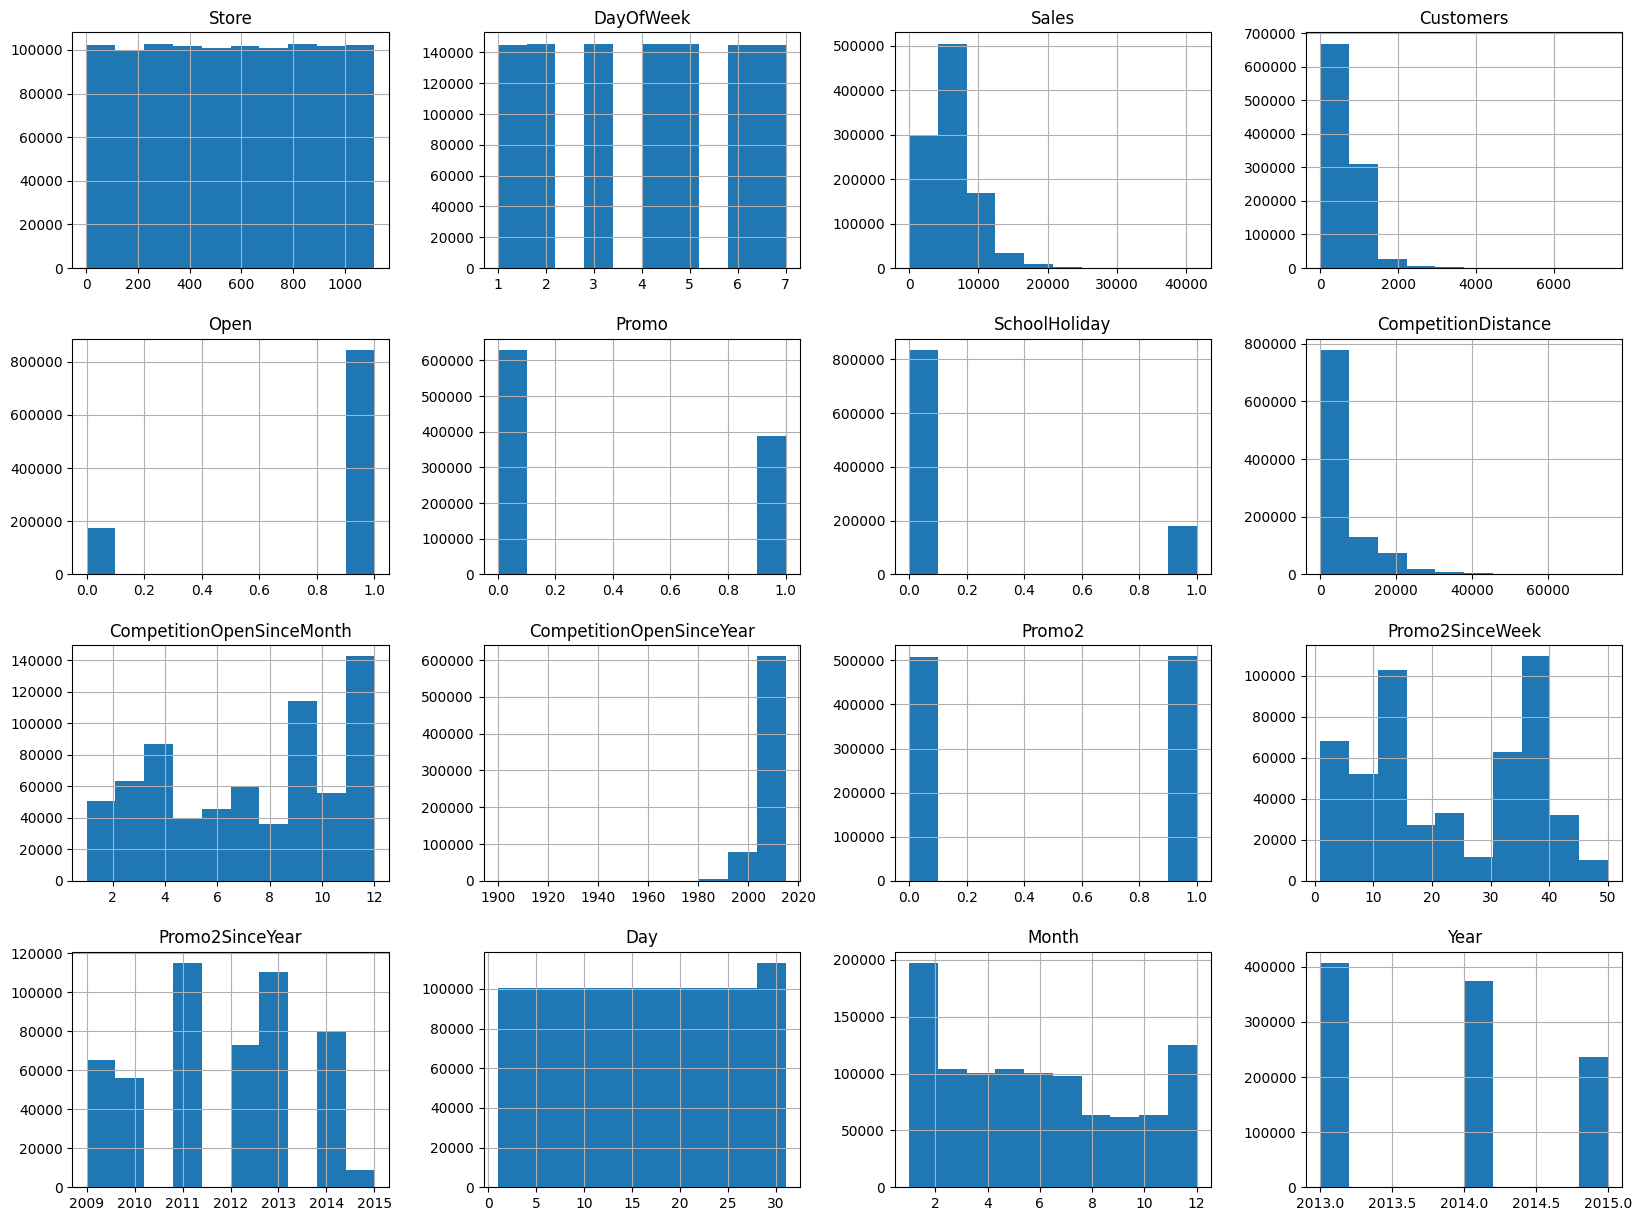

In [37]:
# Histograma de las variables numericas (Train)
numerical_features = list(train_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train_df[numerical_features].hist(figsize=(20,15));

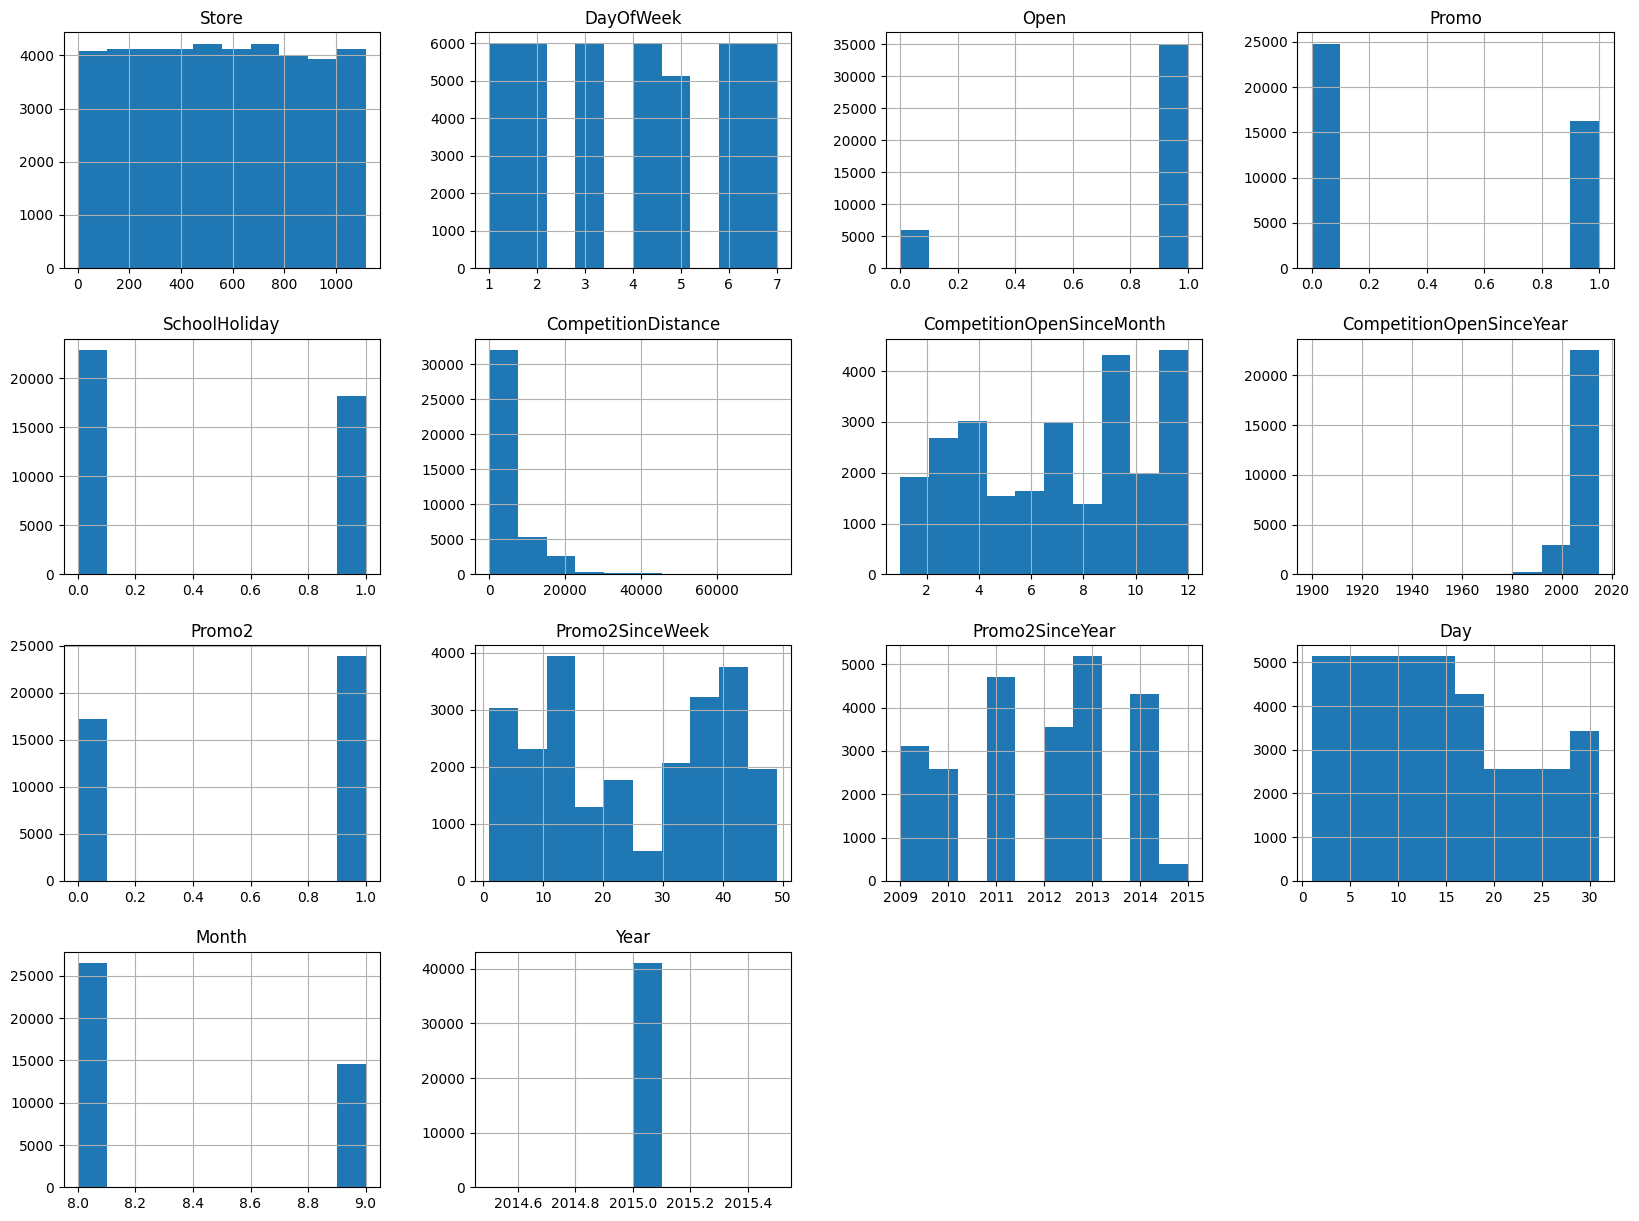

In [38]:
#Numerical Features Histograms (Test)
numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test_df[numerical_features].hist(figsize=(20,15));

In [39]:
numerical_features

['Store',
 'DayOfWeek',
 'Open',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Day',
 'Month',
 'Year']

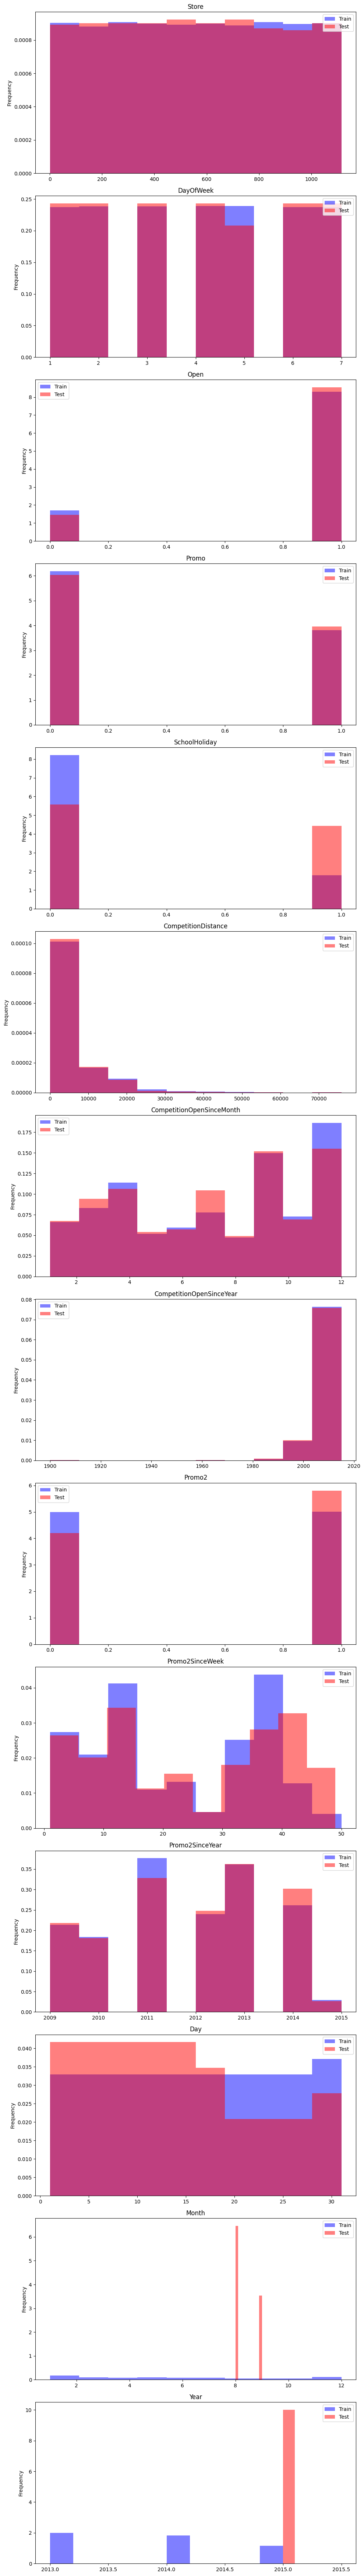

In [40]:
# Características numéricas
# Se usan solo las variables de test porque train tiene variables que test no posee
numerical_features = list(test_df.select_dtypes(include=['int64', 'float64', 'int32']).columns)

# Crea una figura y un conjunto de subgráficos
fig, axs = plt.subplots(len(numerical_features), figsize=(10, 5*len(numerical_features)))

# Para cada característica numérica
for i, feature in enumerate(numerical_features):
    # Histograma de entrenamiento
    train_df[feature].plot(kind='hist', density=True, alpha=0.5, ax=axs[i], color='blue', label='Train')
    
    # Histograma de prueba
    test_df[feature].plot(kind='hist', density=True, alpha=0.5, ax=axs[i], color='red', label='Test')
    
    # Título y leyenda
    axs[i].set_title(feature)
    axs[i].legend()

# Muestra la figura
plt.tight_layout()
plt.show()

El dataset de test no posee la variable __Customers__ por lo que no puede ser usada directamente el entrenamiento. Aunque potencialmente se podría usar para agrupar las tiendas. 

Para las demás variables la distribución es bastante similar entre dataset con la excepción de __SchoolHoliday__, dónde el dataset de test tiene una mayor frecuencia de 1s. 

In [41]:
# Casteo de variables numericas y categóricas
numeric_cols = ['Store', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekOfYear']
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment', 'Promo', 'SchoolHoliday',
                   'Promo2']

train_df[categorical_cols] = train_df[categorical_cols].astype(str)
test_df[categorical_cols] = test_df[categorical_cols].astype(str)

/var/folders/y7/l23wtszj75d_zt0zdmx438vr0000gn/T/ipykernel_91218/3304150318.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(train_df["Sales"])


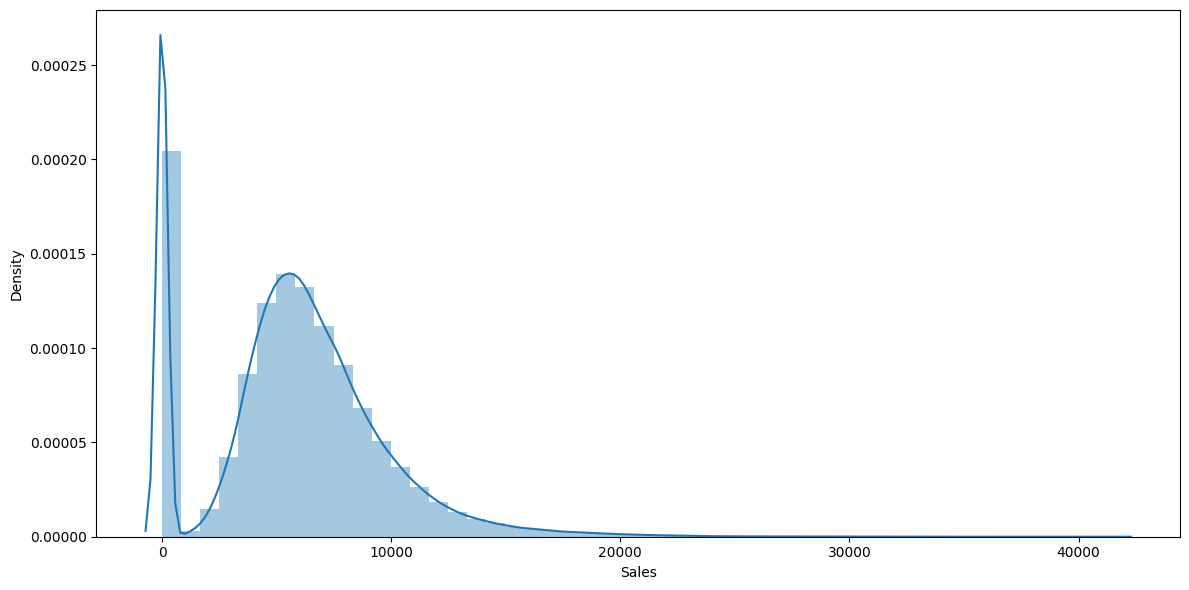

In [42]:
# Plot a histogram of the Sales column
plt.figure(figsize=(12,6))
ax = sns.distplot(train_df["Sales"])
plt.tight_layout()
plt.show()

La distribución de la variable ventas es bastante peculiar. Por un lado existen una gran cantidad de valores 0, hecho que podría ser explicado por otras variables. Por otro lado, la distribución de los valores positivos es relativamente simétrico en cuanto a la similitud de la media y mediana, aunque con una cola muy pesada hacia la derecha. 

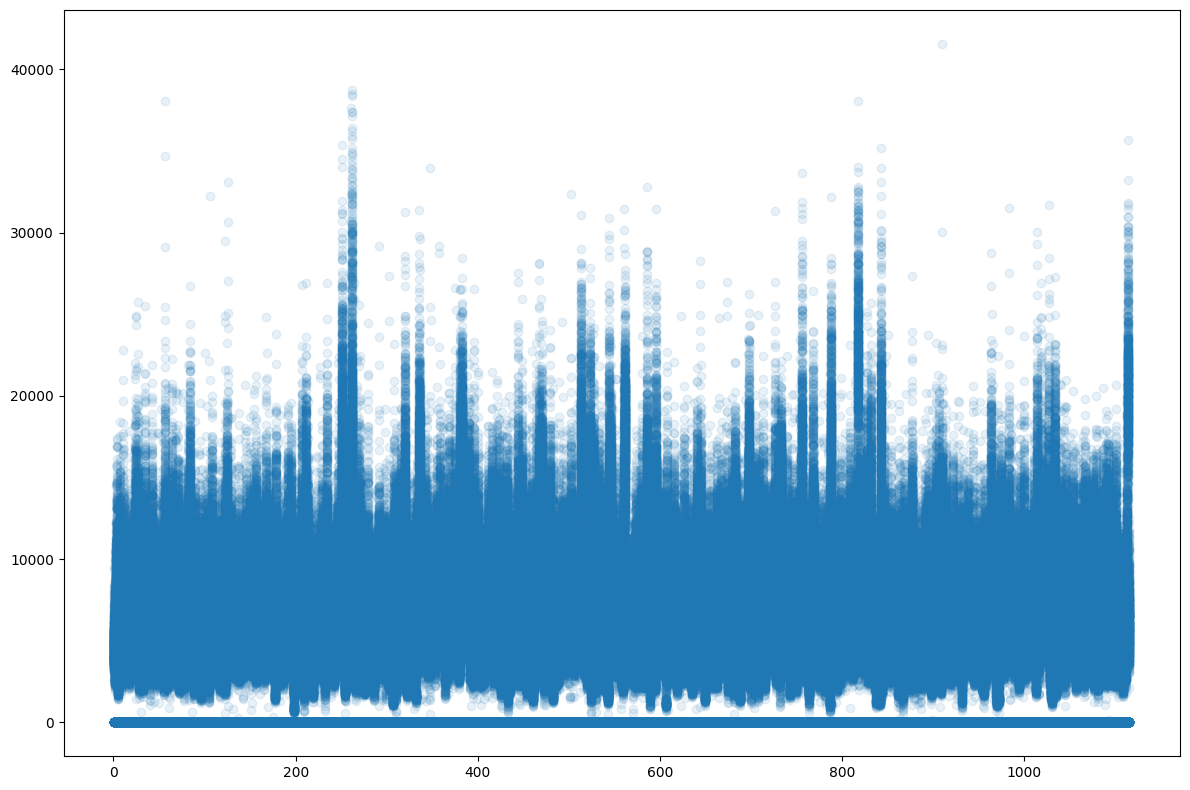

In [43]:
#Sales_Stores
plt.figure(figsize=(12, 8))
plt.scatter(train_df['Store'],train_df['Sales'], alpha=0.1);
plt.tight_layout()

Nuevamente se ve que hay muchas tiendas con ventas por encima de los 18000-20000 mientras que también que una gran cantidad tienen valores de 0, lo que podría indicar que las tiendas están cerradas. 

In [44]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

La alta densidad de valores de 0 clientes confirma que las ventas nulas se deben a que la tienda estuvo cerrada. Es necesario identificar el motivo por el cuál la tienda estuvo cerrada. Las variables relacionadas a las vacaciones o feriados y a tienda cerrada podrían explicar este comportamiento.

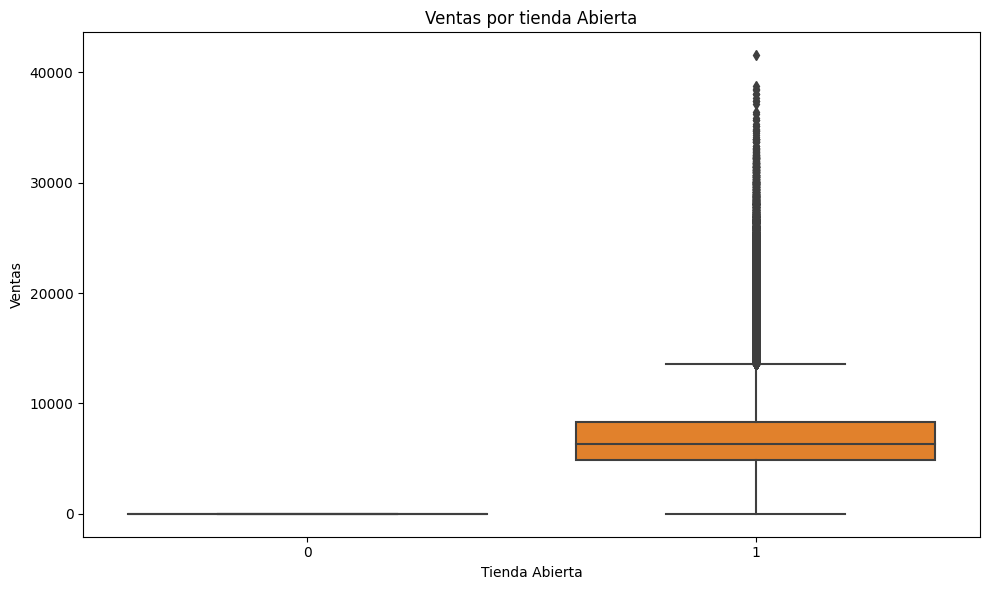

In [45]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="Open", y="Sales")
ax.set_title("Ventas por tienda Abierta")
ax.set_xlabel("Tienda Abierta")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

Como era de esperarse, cuando la tienda está cerrada, las ventas son cero. Sin embargo, cuando está abierta existe una gran dispersión en las ventas. Es necesario identificar cuáles otras variables podrían estar actuando. 

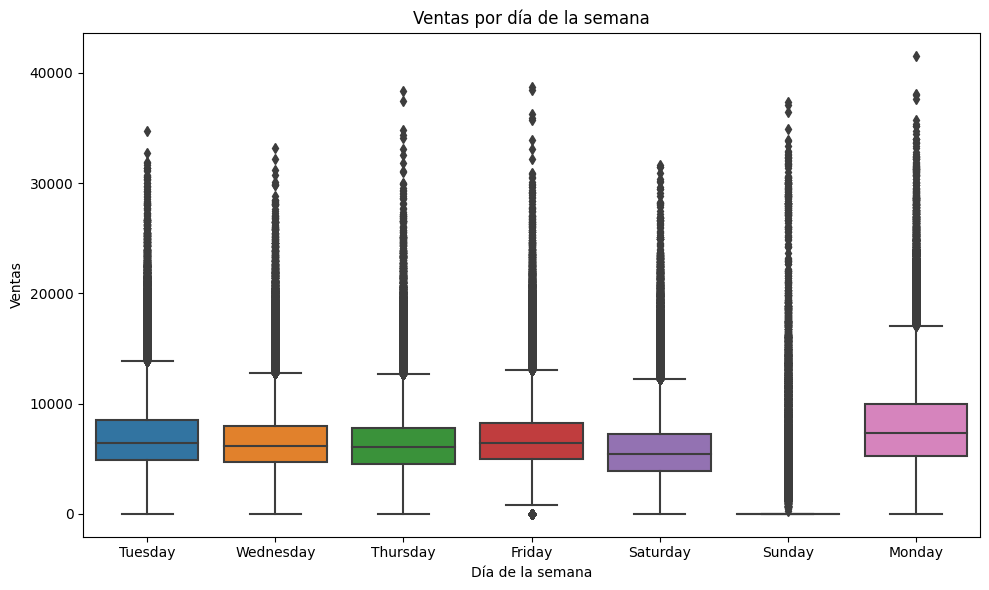

In [46]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="DayName", y="Sales")
ax.set_title("Ventas por día de la semana")
ax.set_xlabel("Día de la semana")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

In [47]:
train_df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,DayName
Date,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,1,2013,1,1,Tuesday
2013-01-02,1,3,5530,668,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,1,2013,1,1,Wednesday
2013-01-03,1,4,4327,578,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,1,2013,1,1,Thursday
2013-01-04,1,5,4486,619,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,1,2013,1,1,Friday
2013-01-05,1,6,4997,635,1,0,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,1,2013,1,1,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-07-27,1115,1,10712,608,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",27,7,2015,31,31,Monday
2015-07-28,1115,2,8093,500,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",28,7,2015,31,31,Tuesday
2015-07-29,1115,3,7661,473,1,1,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",29,7,2015,31,31,Wednesday


Las ventas son relativamente similares durante toda la semana a excepción del domingo. Una proporción importante de las tiendas permanece cerrada ese dia aunque si hay algunas ventas por alguna razón. 

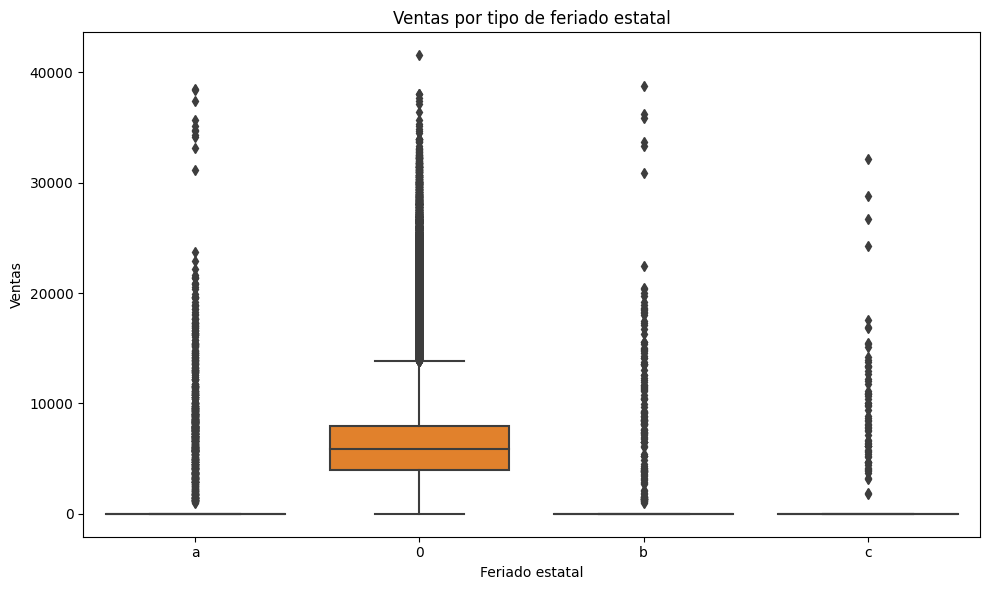

In [48]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="StateHoliday", y="Sales")
ax.set_title("Ventas por tipo de feriado estatal")
ax.set_xlabel("Feriado estatal")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

No hay una diferencia importante entre los distintos tipos de feriados estatales, aunque lógicamente cuando no los hay, las tiendas tienen ventas positivas. 

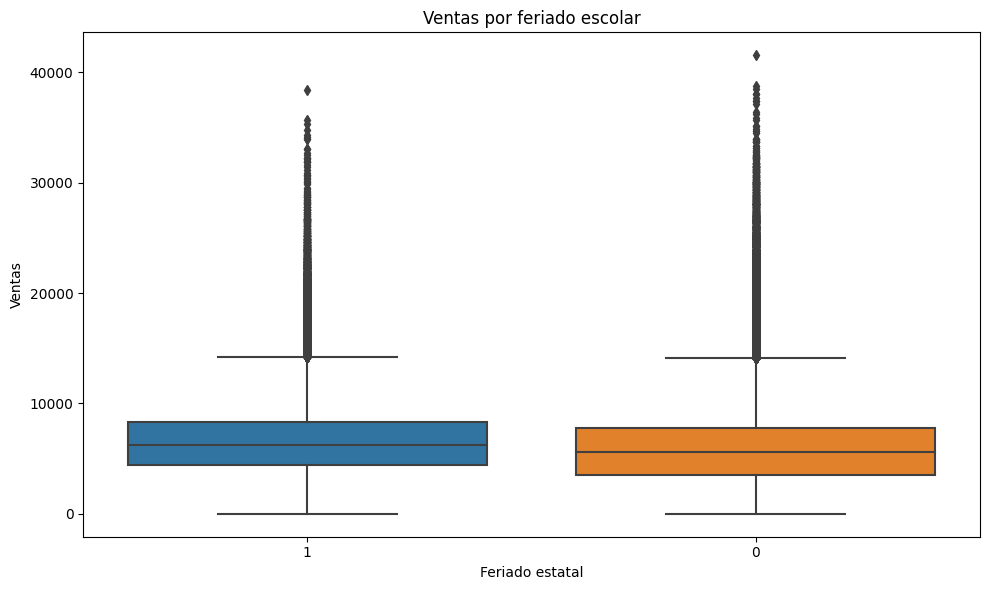

In [49]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=train_df, x="SchoolHoliday", y="Sales")
ax.set_title("Ventas por feriado escolar")
ax.set_xlabel("Feriado estatal")
ax.set_ylabel("Ventas")
plt.tight_layout()
plt.show()

Los feriados escolares parecen no tener un mayor efecto sobre las ventas a nivel agregado. Esto no quiere decir que para algunas tiendas en particular esta variable no sea útil. 

**A partir del análisis anterior se podría pensar que cuando se dan ciertas condiciones, como feriados estatales, las ventas podrían harcodearse a 0. Esta afirmación es un poco temeraria y deberia ser comprobada.**

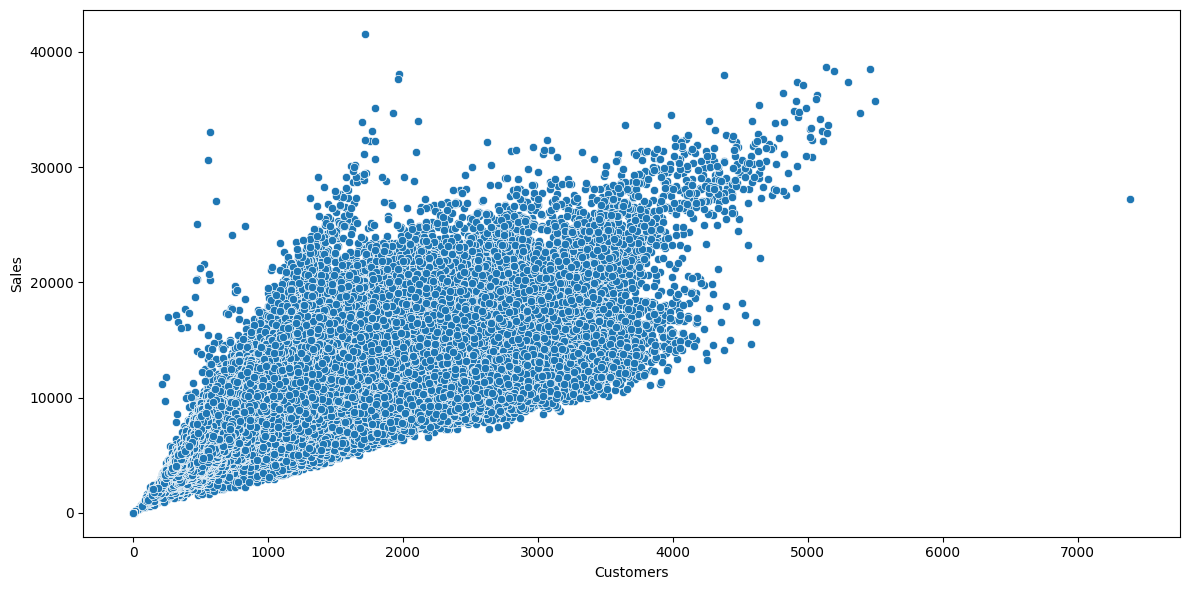

In [50]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = train_df["Customers"],y=train_df["Sales"])
plt.tight_layout()

Existe una relación positiva y bastante lineal entre $Sales$ y $Customers$, esto es bastante lógico ya que a mayor cantidad de clientes, las ventas totales son mayores. La forma de abanico de los distribución hace pensar que el ticket promedio por día y por tienda es muy diferente, especialmente hacia las colas de las distribuciones. Esta podría ser una variable interesante a incluir. 

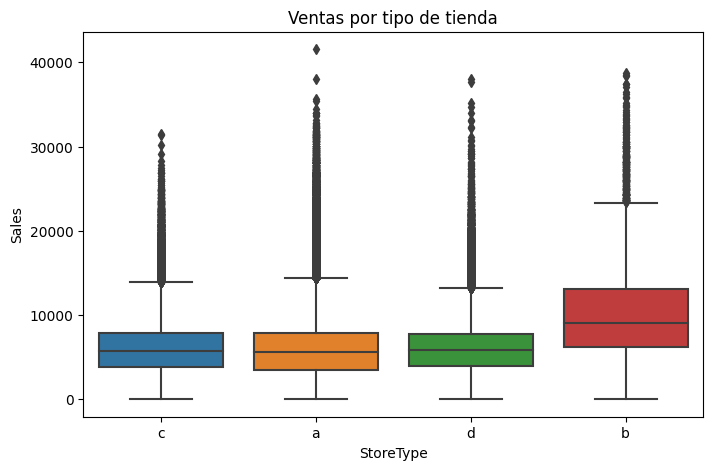

In [51]:
# Ventas por tipo de tienda
plt.figure(figsize=(8,5))
sns.boxplot(data=train_df, x="StoreType", y="Sales")
plt.title("Ventas por tipo de tienda")
plt.xlabel("StoreType")
plt.ylabel("Sales")
plt.show()

El tipo de tienda _b_ es diferente a los demás y tiene ventas por encima de las demás. Seria interesante explorar si los tickets promedio de estas tiendas también son mayores y explicaria la variabilidad mostrada en el diagrama de dispersión anterior. 

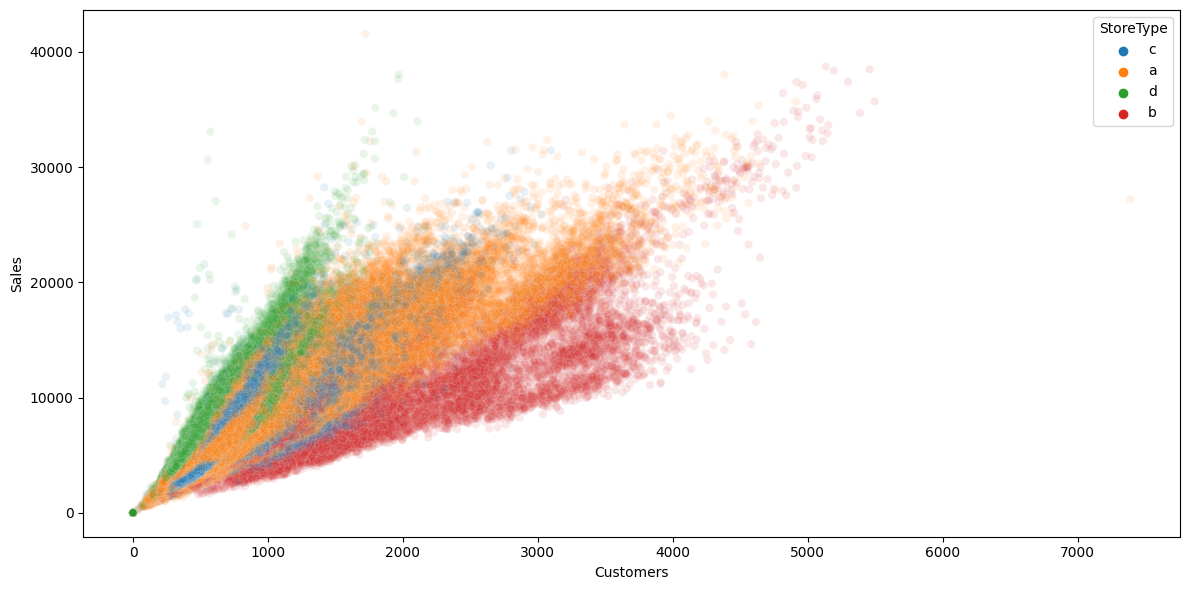

In [52]:
plt.figure(figsize=(12,6))

# Para crear colores distintos para cada StoreType
#colors = {'a':'red', 'b':'blue', 'c':'green', 'd':'yellow'}

sns.scatterplot(x=train_df["Customers"], y=train_df["Sales"], hue=train_df['StoreType'], alpha = 0.1)
plt.tight_layout()
plt.show()


Se puede ver una clara diferencia entre los tipos de tienda. Las tiendas _b_ tienden a tener menos ventas diarias pero una mayor cantidad de clientes. En el otro extremo, las tiendas _d_ tienen menos clientes pero una mayor cantidad de ventas lo que indica un mayor ticket promedio. 

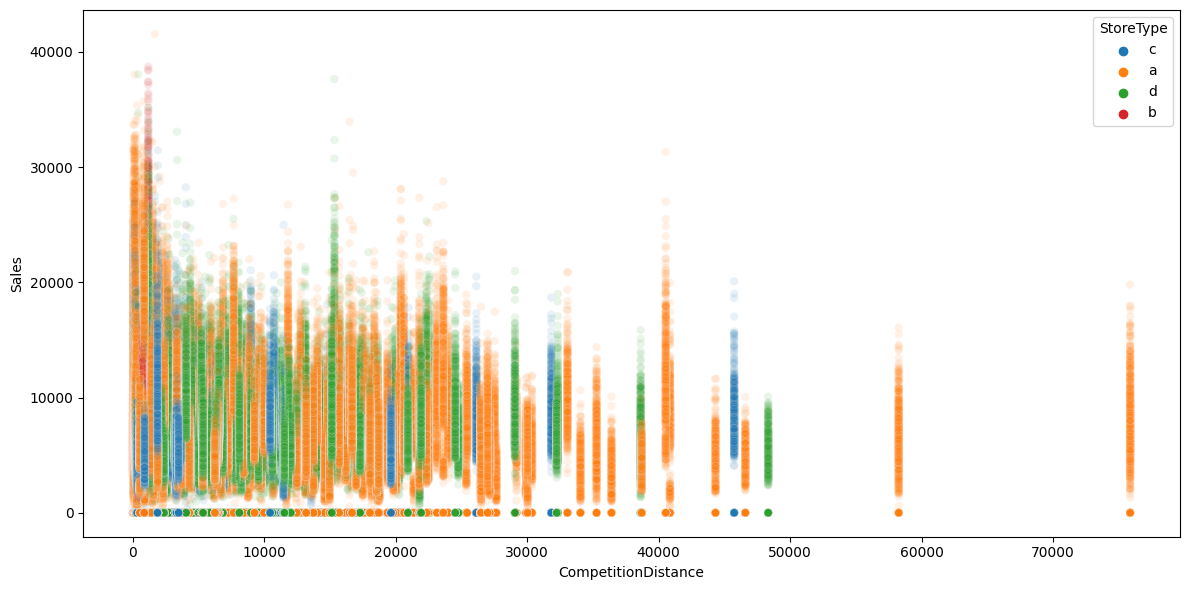

In [53]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = train_df["CompetitionDistance"],y=train_df["Sales"], hue=train_df['StoreType'], alpha = 0.1)
plt.tight_layout()

Parecería no existir una relación negativa entre la distancia de la competencia y las ventas. Aún a distancias cortas se dan ventas muy altas y otras más bajas. 

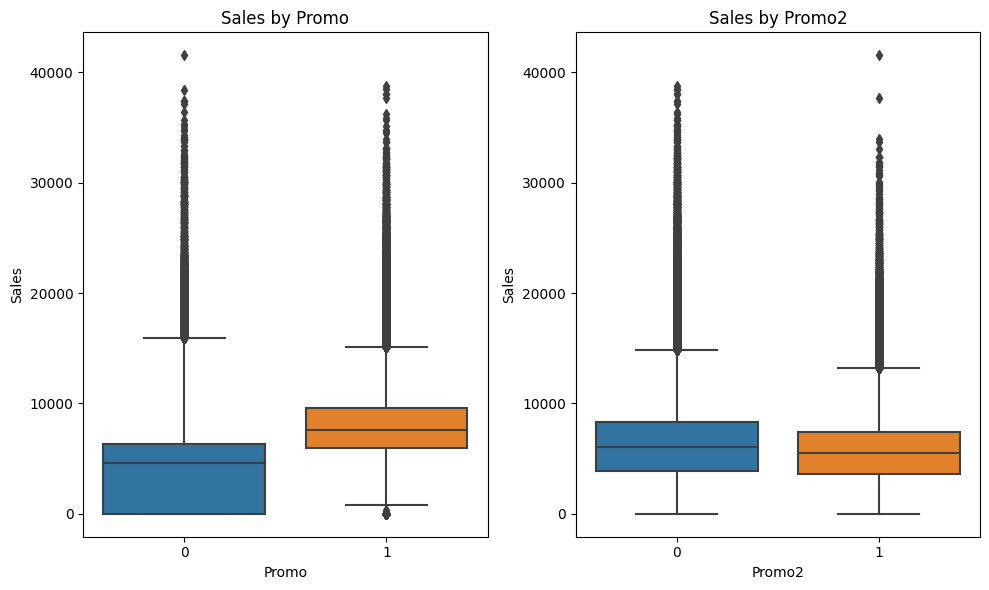

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

sns.boxplot(data=train_df, x="Promo", y="Sales", ax=axes[0])
axes[0].set_title("Sales by Promo")
axes[0].set_xlabel("Promo")
axes[0].set_ylabel("Sales")

sns.boxplot(data=train_df, x="Promo2", y="Sales", ax=axes[1])
axes[1].set_title("Sales by Promo2")
axes[1].set_xlabel("Promo2")
axes[1].set_ylabel("Sales")

fig.tight_layout()
plt.show()


Las promociones afectan positivamente a las ventas. Es decir, cuando una tienda ofrece una promoción, las ventas aumentan. Sin embargo, cuando la promoción continua, como indica _Promo2_, las ventas no se modifican o incluso disminuyen. Sería interesante conocer el motivo detrás de esto. Una posibilidad sería que luego de la primer promoción la cantidad de clientes disminuya porque ya han realizado sus compras sirviéndose de los primeros descuentos. 

In [55]:
ventas_promo2 = train_df.groupby(by='Promo2')[['Sales','Customers']].sum().assign(SalesPerCustomer = lambda x: x['Sales'] / x['Customers'])
ventas_promo2

,Sales,Customers,SalesPerCustomer
Promo2,,,
0,3111542628,357125490,8.712743
1,2761637995,286916265,9.625240


Al evaluar la sumatoria de las ventas se ve que su disminución se debe a la menor afluencia de clientes. Sería necesario explorar el motivo de esta disminución. 

### Analisis de la temporalidad

<Axes: xlabel='Day', ylabel='Sales'>

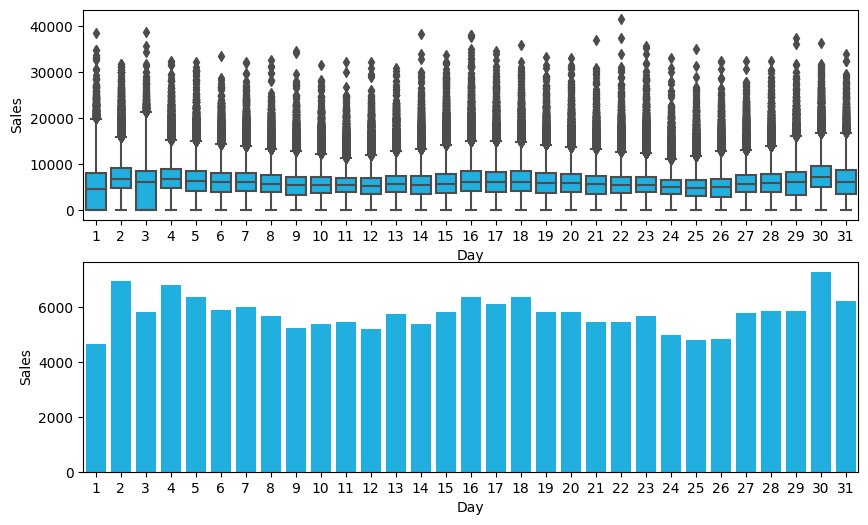

In [56]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

day_df = train_df.groupby("Day")["Sales"].mean().to_frame().reset_index()
# Boxplot
sns.boxplot(x=train_df["Day"],y=train_df["Sales"], color="deepskyblue", ax=axes[0])
# Barplot
sns.barplot(x=day_df["Day"],y=day_df["Sales"], color="deepskyblue", ax=axes[1])


Las ventas son relativamente parejas dentro de cada mes. Aunque los dias 1 y 3 son los únicos con al menos un 25% de valores de 0. Sería interesante ver qué sucede esos dias. Por otro lado, los outliers parece tener una ligera estacionalidad quincenal. 

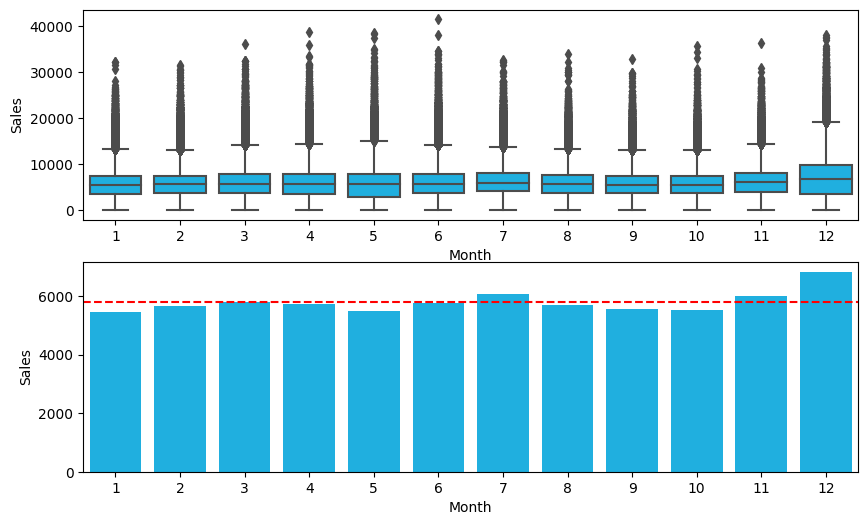

In [57]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

month_df = train_df.groupby("Month")["Sales"].mean().to_frame().reset_index()
# Boxplot
sns.boxplot(x=train_df["Month"],y=train_df["Sales"], color="deepskyblue", ax=axes[0])
# Barplot
sns.barplot(x=month_df["Month"],y=month_df["Sales"], color="deepskyblue", ax=axes[1])

# Adding average line
average_sales = month_df["Sales"].mean()
axes[1].axhline(average_sales, color='r', linestyle='--')

plt.show()


Las ventas durante el año no parecen tener una estacionalidad marcada. Si el mes de diciembre, en coincidencia con la Navidad, presenta las mayores ventas, aunque también la mayor variabilidad durante el año. Las ventas de Noviembre, Julio también se encuentran por encima de la media. 

<Axes: xlabel='Year', ylabel='Sales'>

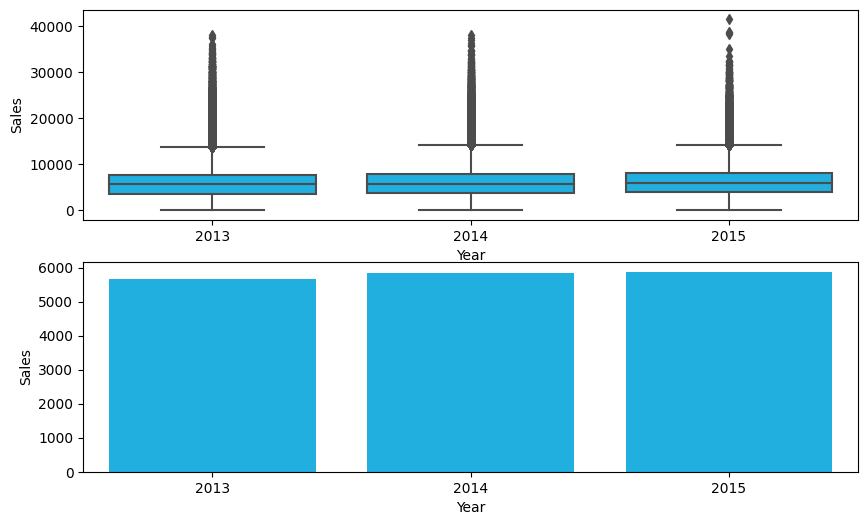

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

year_df = train_df.groupby("Year")["Sales"].mean().to_frame().reset_index()
# Boxplot
sns.boxplot(x=train_df["Year"],y=train_df["Sales"], color="deepskyblue", ax=axes[0])
# Barplot
sns.barplot(x=year_df["Year"],y=year_df["Sales"], color="deepskyblue", ax=axes[1])


Las ventas parecen aumentar con los años pero se trata de una diferencia muy sutil. 

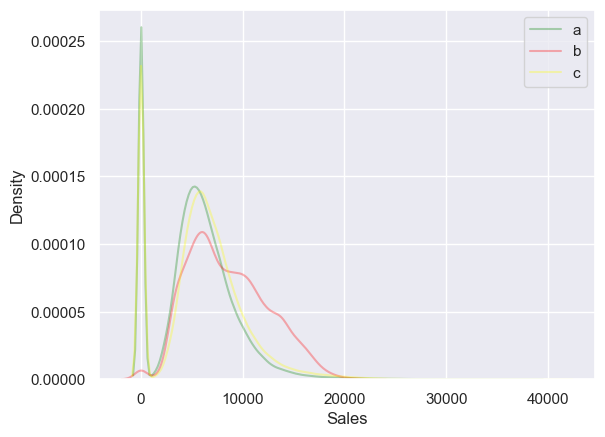

In [59]:
sns.set()
sns.kdeplot(train_df[train_df['Assortment'] == 'a'].Sales, color='green', alpha=0.3, label = 'a')
sns.kdeplot(train_df[train_df['Assortment'] == 'b'].Sales, color='red', alpha=0.3, label = 'b')
sns.kdeplot(train_df[train_df['Assortment'] == 'c'].Sales, color='yellow', alpha=0.3, label = 'c')
plt.legend()
plt.show()

Las tiendas con _Assorment_ tipo "b" parecen tienen menos ventas que las demás. 

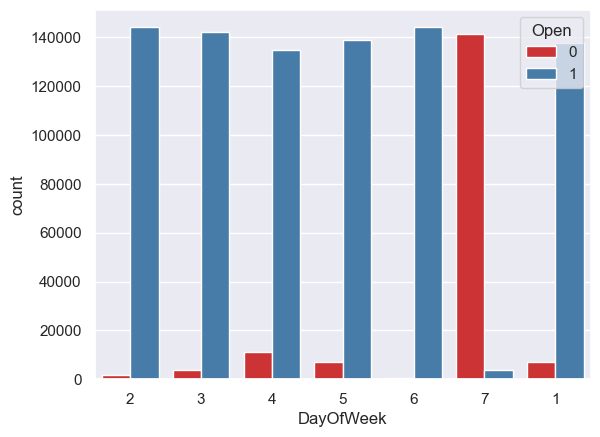

In [60]:
# Cantidad de tiendas abiertas por dia de la semana
sns.countplot( x='DayOfWeek', data=train_df, hue="Open", palette="Set1");

Casi todas las tiendas están cerradas durante el fin de semana. Esto confirma que el dia 7 de la semana se corresponde con el domingo. 

<Axes: >

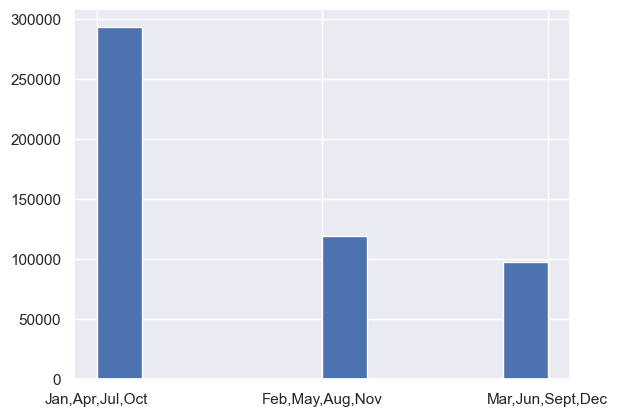

In [61]:
# Histograma de PromoInterval
train_df['PromoInterval'].hist()

La gran mayoría de las promociones se concentran en los meses de enero, abril, julio y octubre. 

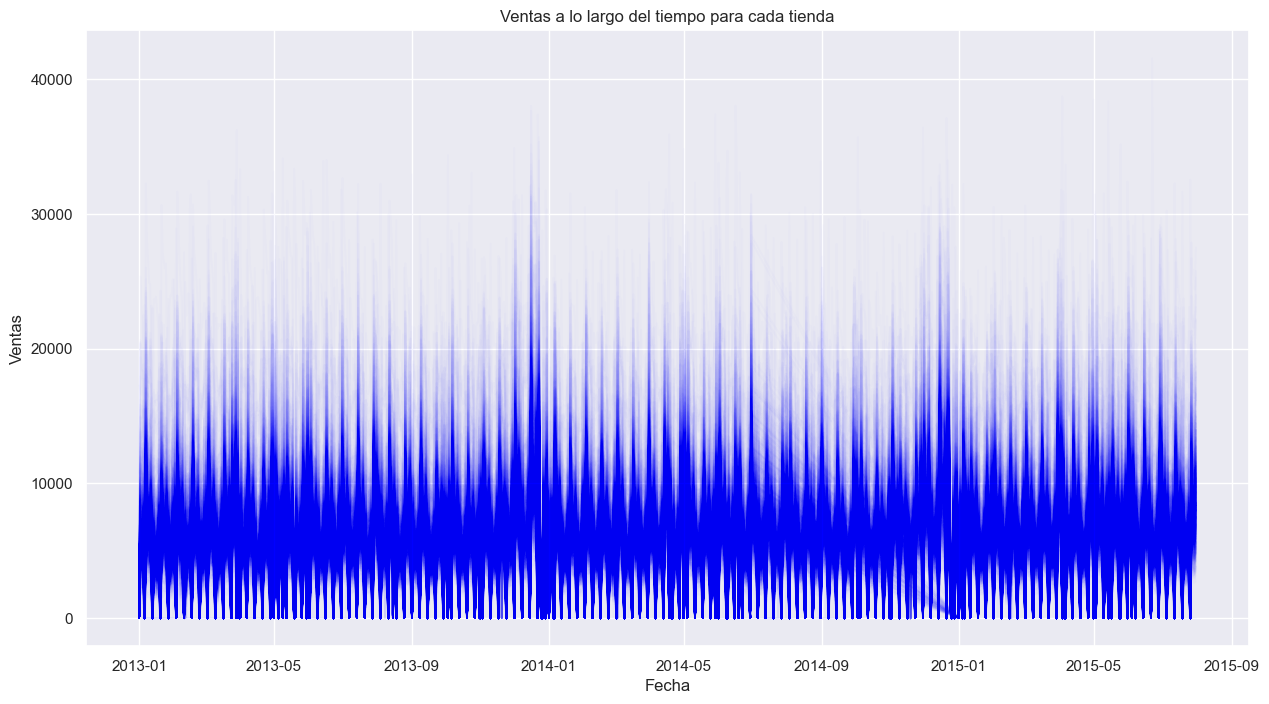

In [63]:
import matplotlib.pyplot as plt

# Crea una lista de todas las tiendas únicas
stores = train_df['Store'].unique()

plt.figure(figsize=(15, 8))

# Itera sobre cada tienda y traza las ventas de esa tienda
for store in stores:
    store_df = train_df[train_df['Store'] == store]
    plt.plot(store_df.index, store_df['Sales'], color='blue', alpha=0.01)

plt.title('Ventas a lo largo del tiempo para cada tienda')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.show()


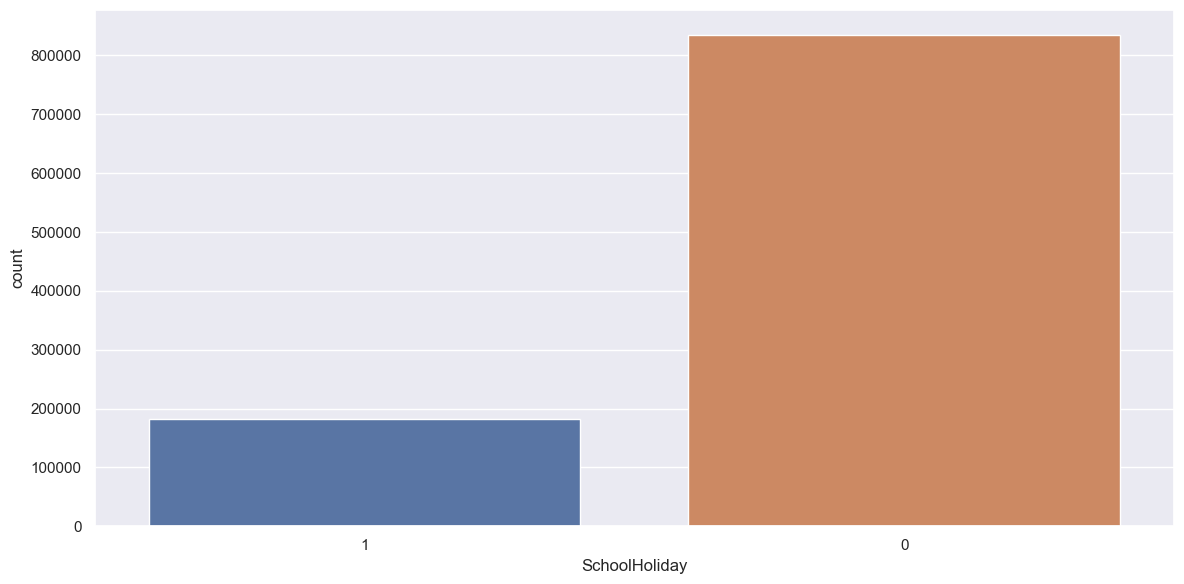

In [64]:
plt.figure(figsize=(12,6))
sns.countplot(x = train_df["SchoolHoliday"])
plt.tight_layout()

# Feature engineering

In [14]:
# Agrupar por tienda y calcular métricas
store_data = train_df.groupby('Store').agg(
    SalesPerDay=('Sales', 'mean'), 
    CustomersPerDay=('Customers', 'mean'),
    TotalDays=('Open', 'count')
)

# Calcular métricas adicionales
store_data['AvgSalesPerCustomer'] = store_data['SalesPerDay'] / store_data['CustomersPerDay']

# Mapear las métricas a los dataframes de entrenamiento y prueba
train_df = train_df.join(store_data, on='Store')
test_df = test_df.join(store_data, on='Store')


In [15]:
# Agrupar por tienda y calcular métricas
store_data = train_df.groupby(['Store', 'Month']).agg(
    SalesPerMonth=('Sales', 'sum'), 
    CustomersPerMonth=('Customers', 'sum')
)


# Mapear las métricas a los dataframes de entrenamiento y prueba
train_df = train_df.join(store_data, on=['Store', 'Month'])
test_df = test_df.join(store_data, on=['Store', 'Month'])

In [16]:
'''
import pandas as pd
import statsmodels.api as sm

def stl_decompose(df, store, period=30):
    # Selecciona las ventas de la tienda específica
    store_df = df[df['Store'] == store]
    sales = store_df['Sales']
    
    # Realiza la descomposición STL
    result = sm.tsa.seasonal_decompose(sales, model='additive', period=period)
    
    # Crea un DataFrame para los componentes de estacionalidad
    seasonal_df = pd.DataFrame({
        'Store': store,
        'DayOfYear': store_df['DayOfYear'],
        'Year': store_df['Year'],
        'Sales_Seasonality': result.seasonal
    })
    return seasonal_df

# Crea un DataFrame vacío para almacenar los resultados
seasonality_df = pd.DataFrame()

# Aplica la función a cada tienda y concatena los resultados
for store in train_df['Store'].unique():
    store_seasonality = stl_decompose(train_df, store)
    seasonality_df = pd.concat([seasonality_df, store_seasonality])

seasonality_df.reset_index(drop=True, inplace=True)

# Agregar a los dataset de train y test
#train_df = train_df.merge(seasonality_df)
#test_df = test_df.merge(seasonality_df)
'''

"\nimport pandas as pd\nimport statsmodels.api as sm\n\ndef stl_decompose(df, store, period=30):\n    # Selecciona las ventas de la tienda específica\n    store_df = df[df['Store'] == store]\n    sales = store_df['Sales']\n    \n    # Realiza la descomposición STL\n    result = sm.tsa.seasonal_decompose(sales, model='additive', period=period)\n    \n    # Crea un DataFrame para los componentes de estacionalidad\n    seasonal_df = pd.DataFrame({\n        'Store': store,\n        'DayOfYear': store_df['DayOfYear'],\n        'Year': store_df['Year'],\n        'Sales_Seasonality': result.seasonal\n    })\n    return seasonal_df\n\n# Crea un DataFrame vacío para almacenar los resultados\nseasonality_df = pd.DataFrame()\n\n# Aplica la función a cada tienda y concatena los resultados\nfor store in train_df['Store'].unique():\n    store_seasonality = stl_decompose(train_df, store)\n    seasonality_df = pd.concat([seasonality_df, store_seasonality])\n\nseasonality_df.reset_index(drop=True, inpl

In [17]:
test_df[(test_df["Store"] == 1115) & (test_df["Year"] == 2015) & (test_df["DayOfYear"] == 1)]

,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,DayName,SalesPerDay,CustomersPerDay,TotalDays,AvgSalesPerCustomer,SalesPerMonth,CustomersPerMonth
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,


No es posible identificar la estacionalidad para toda la serie temporal porque los datos de test tienen fechas posteriores a las de train. Se aproxima este patron calculado estadisticas descriptivas por tienda y por mes. 

Se calculará por mes y para todas las tiendas

### Conversion de fechas a enteros

In [18]:
# Variables relacionadas con la apertura de la competencia
variables = ['CompetitionOpenSinceMonth','CompetitionOpenSinceYear']

# Se obtiene la moda para cada una de estas variables
modas = train_df[variables].mode()

# Se reemplazan los valores nulos por la moda en cada dataset
for variable in variables:
    train_df[variable].fillna(modas[variable][0], inplace=True)
    test_df[variable].fillna(modas[variable][0], inplace=True)

# Función para convertir el año y mes de apertura de la competencia a una fecha
def convertir_apertura_competencia(df):
    try:
        fecha = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(fecha)
    except:
        return np.nan

# Aplicamos la función y convertimos a un entero para obtener una representación continua en segundos
train_df['CompetitionOpenInt'] = train_df.apply(lambda df: convertir_apertura_competencia(df), axis=1).astype(np.int64)
test_df['CompetitionOpenInt'] = test_df.apply(lambda df: convertir_apertura_competencia(df), axis=1).astype(np.int64)


### Variables derivadas de las promociones

TODO: Esta funcion dejo de funcionar luego de la actualizacion de Pandas. Debo ver el motivo

In [19]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        elif pd.isna(row['Promo2Open']) or pd.isna(row['Month']):
            return np.nan
        else:
            return 0
    except Exception:
        return np.nan  # Retorna np.nan si hay una excepción



def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2'] = df['Promo2'].astype(float)
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0)
    df['Promo2Open'] = np.nan_to_num(df['Promo2Open']) * df['Promo2']  # Reemplaza NaN antes de la operación
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']
    df['IsPromo2Month'] = df['IsPromo2Month'].fillna(np.nan)  # Reemplaza los NaN después del cálculo

In [20]:
#promo_cols(train_df)
#promo_cols(test_df)

### Variables derivadas de la competencia

In [21]:
# Define los intervalos de distancia en metros
bins = [0, 200, 500, 1000, 2000, 5000, np.inf]
# Define las etiquetas para cada intervalo
labels = ['Muy cerca', 'Cerca', 'Media distancia', 'Lejos', 'Muy lejos', 'Extremadamente lejos']

# Crea una nueva variable 'CompetitionDensity' basada en los intervalos definidos
# Usando 'Lejos' para los valores faltantes
train_df['CompetitionDistance'].fillna(np.inf, inplace=True)
train_df['CompetitionDensity'] = pd.cut(train_df['CompetitionDistance'], bins=bins, labels=labels)
train_df['CompetitionDistance'].replace(np.inf, np.nan, inplace=True)


test_df['CompetitionDensity'] = pd.cut(test_df['CompetitionDistance'], bins=bins, labels=labels)


In [22]:
# Agrupar por 'CompetitionDensity' y calcular métricas
competition_data = train_df.groupby(['CompetitionDensity']).agg(
    TotalSales=('Sales', 'sum'),
    TotalCustomers=('Customers', 'sum'),
    AverageSales=('Sales', 'mean'),
    AverageCustomers=('Customers', 'mean'),
    TotalOpenDays=('Open', 'count')
)

# Calcular métricas adicionales
competition_data['SalesPerDayCompetition'] = competition_data['TotalSales'] / competition_data['TotalOpenDays']
competition_data['CustomersPerDayCompetition'] = competition_data['TotalCustomers'] / competition_data['TotalOpenDays']
competition_data['AvgSalesPerCustomerCompetition'] = competition_data['AverageSales'] / competition_data['AverageCustomers']

# Eliminar columnas innecesarias
competition_data.drop(columns=['TotalSales', 'TotalCustomers', 'AverageSales', 'AverageCustomers', 'TotalOpenDays'], inplace=True)

train_df = train_df.join(competition_data, on=[ 'CompetitionDensity'])
test_df = test_df.join(competition_data, on=[ 'CompetitionDensity'])

### Variable derivadas del tipo de tienda

In [23]:
# Agrupar las ventas por 'StoreType' y calcular varias medidas estadísticas
sales_by_store_type = train_df.groupby([ 'StoreType',  'Month']).agg(
        SalesPerStoreTypeMonth=('Sales', 'mean'), 
        CustomersPerStoreTypeMonth=('Customers', 'mean')
)

# Mapear las métricas a los dataframes de entrenamiento y prueba
train_df = train_df.join(sales_by_store_type, on=[ 'StoreType',  'Month'])
test_df = test_df.join(sales_by_store_type, on=[ 'StoreType',  'Month'])


In [24]:
# Reordenar variables
train_df.sort_values(["Store"], ignore_index=True, inplace=True)
test_df.sort_values(["Store"], ignore_index=True, inplace=True)
train_df.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)
test_df.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)

<Axes: >

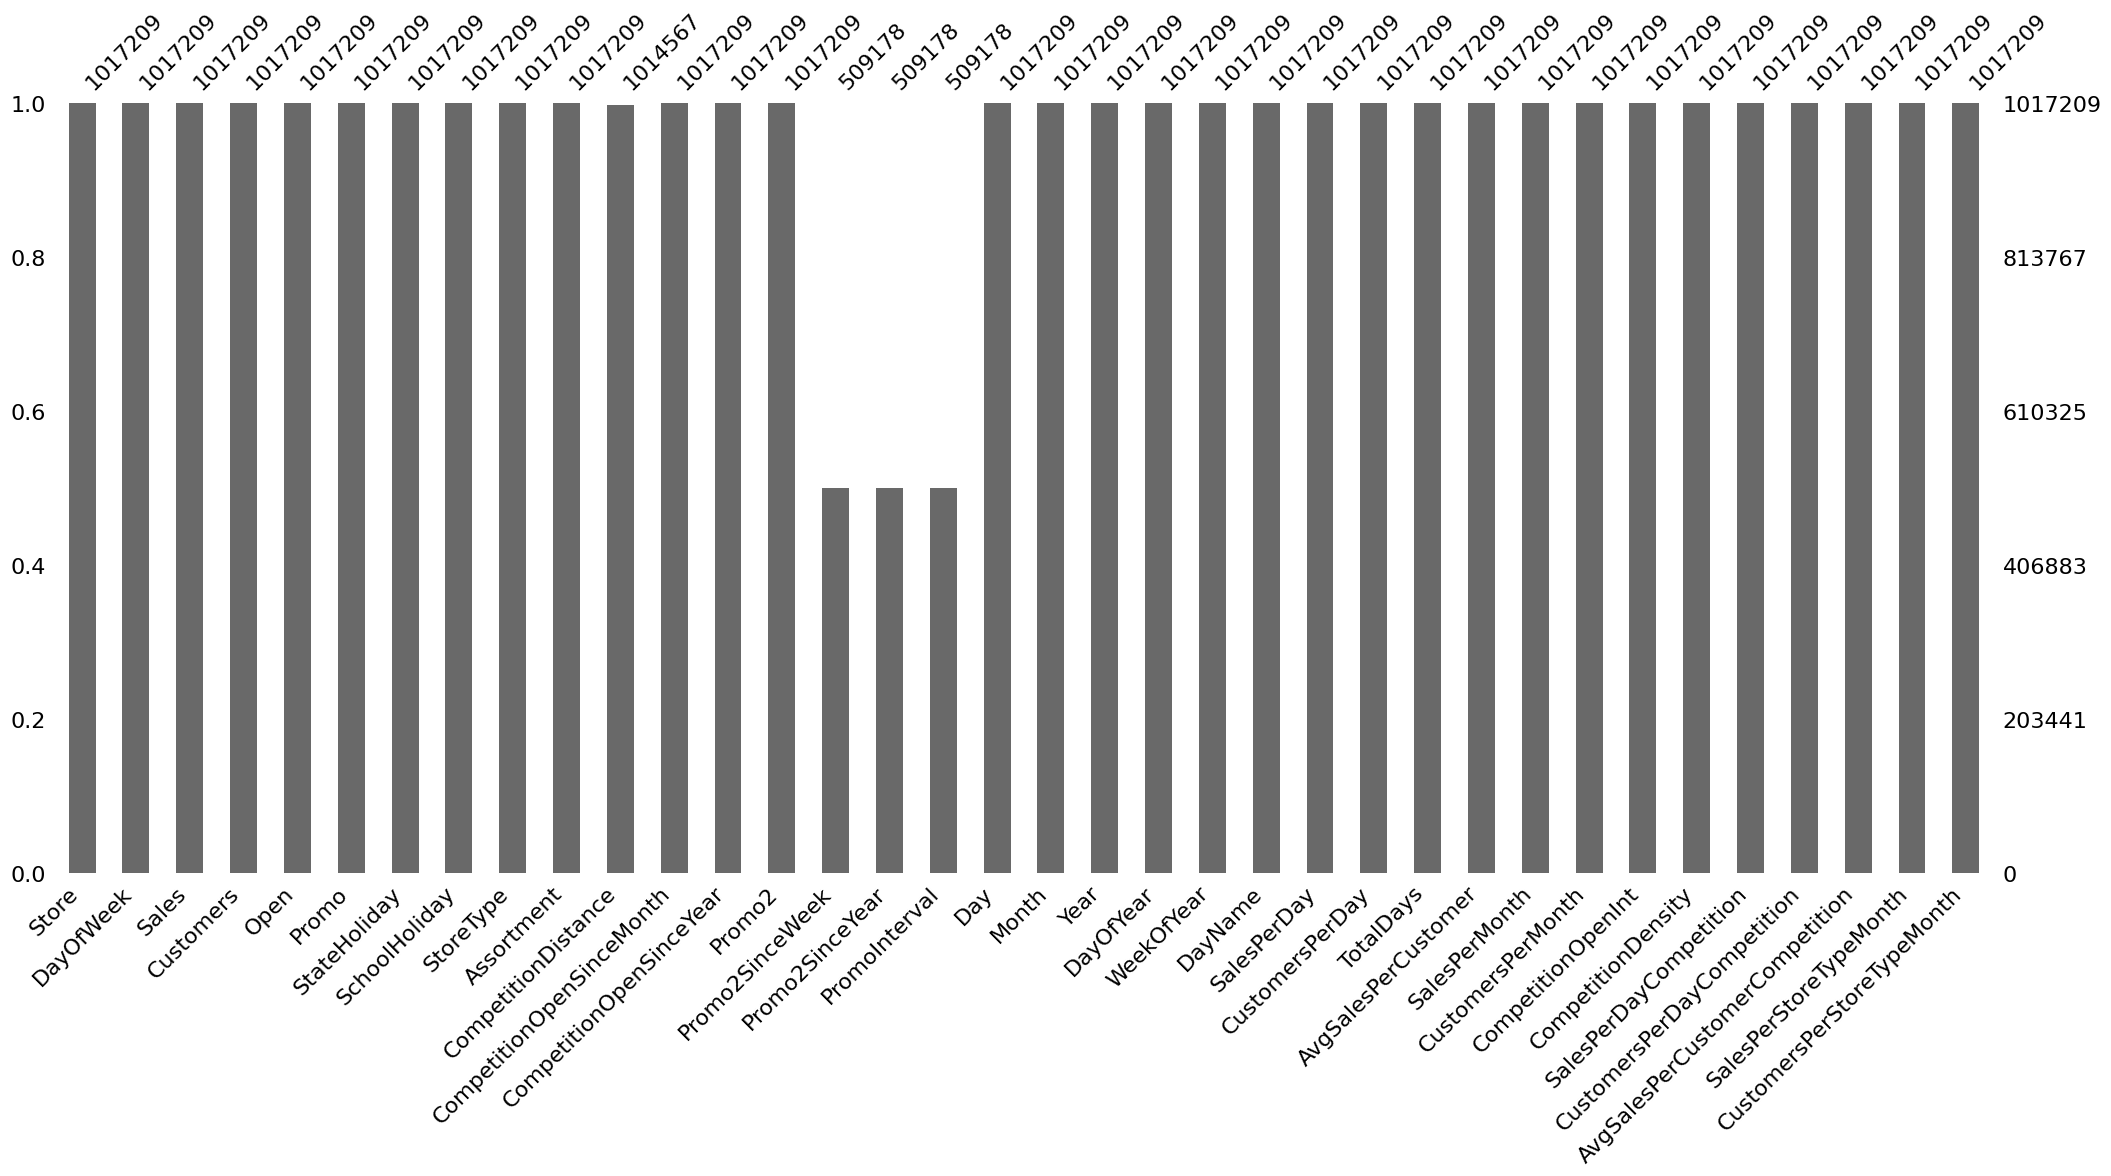

In [25]:
import missingno as msno

msno.bar(train_df)

In [26]:
train_df.CompetitionDistance.isna().sum()

2642

In [27]:
#missing data percentage (Training)
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
PromoInterval,508031,49.9
Promo2SinceYear,508031,49.9
Promo2SinceWeek,508031,49.9
CompetitionDistance,2642,0.3
DayOfYear,0,0.0
DayName,0,0.0
SalesPerDay,0,0.0
CustomersPerDay,0,0.0
TotalDays,0,0.0
AvgSalesPerCustomer,0,0.0


In [28]:
#missing data percentage (Testing)
total = test_df.isnull().sum().sort_values(ascending=False)
percent_1 = test_df.isnull().sum()/test_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data

,Total,%
Promo2SinceYear,17232,41.9
PromoInterval,17232,41.9
Promo2SinceWeek,17232,41.9
AvgSalesPerCustomerCompetition,96,0.2
CustomersPerDayCompetition,96,0.2
SalesPerDayCompetition,96,0.2
CompetitionDensity,96,0.2
CompetitionDistance,96,0.2
Open,11,0.0
Store,0,0.0


In [29]:
missing_features = ['Promo2SinceYear','Promo2SinceWeek','CompetitionDistance', 'PromoInterval']
modes = train_df[missing_features].mode()

for f in missing_features:
        train_df[f] = train_df[f].fillna(modes[f][0])
        test_df[f] = test_df[f].fillna(modes[f][0])
for dataset in (train_df,test_df):
    dataset['Open'] = dataset['Open'].fillna(0)

In [30]:
train_df.drop('DayName',inplace=True,axis=1)
test_df.drop('DayName',inplace=True,axis=1)

## Tiendas abiertas o cerradas

In [31]:
train_df.groupby(by='Open')['Sales'].sum()

Open
0             0
1    5873180623
Name: Sales, dtype: int64

Se eliminan los registros en los que la tienda esta cerrada. Luego serán harcodeados en test

In [32]:
train_df.drop('Customers',inplace = True, axis=1) 

In [33]:
train_df.drop('StateHoliday',inplace=True,axis=1)  #Because it reduces the performance
test_df.drop('StateHoliday',inplace=True,axis=1)

In [34]:
train_df = train_df[train_df.Open == 1].copy() 
train_df.groupby(by='Open')['Sales'].sum()

Open
1    5873180623
Name: Sales, dtype: int64

Ya no hay tiendas cerradas en el dataset de entrenamiento

# Preparación de las variables objetivo y de entrenamiento

#### Solo ventas positivas para el entrenamiento

In [35]:
train_df = train_df[train_df['Open'] == 1]
train_df = train_df[train_df['Sales'] > 0.0]

#### Eliminacion de outliers 

Los outliers se identificaron en ajustes preliminares a partir de los residuos

In [36]:
train_df = train_df[train_df['Sales'] < 25000]  
train_df.reset_index(drop=True)

,Store,DayOfWeek,Sales,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year,DayOfYear,WeekOfYear,SalesPerDay,CustomersPerDay,TotalDays,AvgSalesPerCustomer,SalesPerMonth,CustomersPerMonth,CompetitionOpenInt,CompetitionDensity,SalesPerDayCompetition,CustomersPerDayCompetition,AvgSalesPerCustomerCompetition,SalesPerStoreTypeMonth,CustomersPerStoreTypeMonth
0,1,5,5263,1,1,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,31,3945.704883,467.646497,942,8.437366,371902,42773,1220227200000000000,Lejos,5897.762499,665.522450,8.861854,5935.111028,683.559940
1,2,5,6064,1,1,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015,31,31,4122.991507,486.045648,942,8.482725,404752,51461,1193875200000000000,Media distancia,5565.373637,696.353514,7.992167,6032.583774,684.069668
2,3,5,8314,1,1,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,31,5741.253715,620.286624,942,9.255808,571092,59014,1164931200000000000,Extremadamente lejos,5621.983961,535.402148,10.500488,6032.583774,684.069668
3,4,5,13995,1,1,1,c,c,620.0,9.0,2009.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,31,8021.769639,1100.057325,942,7.292138,766259,101283,1251763200000000000,Media distancia,5565.373637,696.353514,7.992167,5935.111028,683.559940
4,5,5,4822,1,1,1,a,a,29910.0,4.0,2015.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015,31,31,3867.110403,444.360934,942,8.702634,398571,45001,1427846400000000000,Extremadamente lejos,5621.983961,535.402148,10.500488,6032.583774,684.069668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843574,682,2,3375,1,0,1,b,a,150.0,9.0,2006.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2013,1,1,11207.408705,1758.842887,942,6.372035,1040328,161767,1157068800000000000,Muy cerca,6522.393457,851.550610,7.659431,9067.295383,1786.325111
843575,733,2,10765,1,0,1,b,b,860.0,10.0,1999.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2013,1,1,14933.288747,3403.458599,942,4.387680,1280920,291719,938736000000000000,Media distancia,5565.373637,696.353514,7.992167,9067.295383,1786.325111
843576,769,2,5035,1,0,1,b,b,840.0,9.0,2013.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct",1,1,2013,1,1,10825.902335,3081.052017,942,3.513703,884573,254913,1377993600000000000,Media distancia,5565.373637,696.353514,7.992167,9067.295383,1786.325111
843577,948,2,4491,1,0,1,b,b,1430.0,9.0,2013.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct",1,1,2013,1,1,6833.666667,1686.977707,942,4.050834,561587,140527,1377993600000000000,Lejos,5897.762499,665.522450,8.861854,9067.295383,1786.325111


In [37]:
train_df.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'SchoolHoliday',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Day', 'Month',
       'Year', 'DayOfYear', 'WeekOfYear', 'SalesPerDay', 'CustomersPerDay',
       'TotalDays', 'AvgSalesPerCustomer', 'SalesPerMonth',
       'CustomersPerMonth', 'CompetitionOpenInt', 'CompetitionDensity',
       'SalesPerDayCompetition', 'CustomersPerDayCompetition',
       'AvgSalesPerCustomerCompetition', 'SalesPerStoreTypeMonth',
       'CustomersPerStoreTypeMonth'],
      dtype='object')

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843579 entries, 0 to 1017190
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Store                           843579 non-null  int64   
 1   DayOfWeek                       843579 non-null  int64   
 2   Sales                           843579 non-null  int64   
 3   Open                            843579 non-null  int64   
 4   Promo                           843579 non-null  int64   
 5   SchoolHoliday                   843579 non-null  int64   
 6   StoreType                       843579 non-null  object  
 7   Assortment                      843579 non-null  object  
 8   CompetitionDistance             843579 non-null  float64 
 9   CompetitionOpenSinceMonth       843579 non-null  float64 
 10  CompetitionOpenSinceYear        843579 non-null  float64 
 11  Promo2                          843579 non-null  int64   
 12  Promo2

# Encoding de variables categoricas

In [39]:
for col in train_df.columns:
    if train_df[col].dtype == 'object' or train_df[col].dtype == 'category':
        train_df[col] = pd.factorize(train_df[col])[0]
        
for col in train_df.select_dtypes('UInt32').columns:
    train_df[col] = train_df[col].astype('int')
    
for col in train_df.select_dtypes('Float64').columns:
    train_df[col] = train_df[col].astype('int')

In [40]:
for col in test_df.columns:
    if test_df[col].dtype == 'object' or test_df[col].dtype == 'category':
        test_df[col] = pd.factorize(test_df[col])[0]
        
for col in test_df.select_dtypes('UInt32').columns:
    test_df[col] = test_df[col].astype('int')

In [41]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 843579 entries, 0 to 1017190
Data columns (total 33 columns):
 #   Column                          Non-Null Count   Dtype
---  ------                          --------------   -----
 0   Store                           843579 non-null  int64
 1   DayOfWeek                       843579 non-null  int64
 2   Sales                           843579 non-null  int64
 3   Open                            843579 non-null  int64
 4   Promo                           843579 non-null  int64
 5   SchoolHoliday                   843579 non-null  int64
 6   StoreType                       843579 non-null  int64
 7   Assortment                      843579 non-null  int64
 8   CompetitionDistance             843579 non-null  int64
 9   CompetitionOpenSinceMonth       843579 non-null  int64
 10  CompetitionOpenSinceYear        843579 non-null  int64
 11  Promo2                          843579 non-null  int64
 12  Promo2SinceWeek                 843579 non-null 

In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Store                           41088 non-null  int64  
 1   DayOfWeek                       41088 non-null  int64  
 2   Open                            41088 non-null  float64
 3   Promo                           41088 non-null  int64  
 4   SchoolHoliday                   41088 non-null  int64  
 5   StoreType                       41088 non-null  int64  
 6   Assortment                      41088 non-null  int64  
 7   CompetitionDistance             41088 non-null  float64
 8   CompetitionOpenSinceMonth       41088 non-null  float64
 9   CompetitionOpenSinceYear        41088 non-null  float64
 10  Promo2                          41088 non-null  int64  
 11  Promo2SinceWeek                 41088 non-null  float64
 12  Promo2SinceYear                 

In [43]:
import pandas as pd
import numpy as np

# Calcula la matriz de correlación
corr_matrix = train_df.corr().abs()

# Selecciona el triángulo superior de la matriz de correlación
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Encuentra los índices de las columnas con correlación mayor a 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Elimina estas columnas del DataFrame
#train_df = train_df.drop(to_drop, axis=1)
to_drop

['DayOfYear', 'WeekOfYear', 'CompetitionOpenInt']

In [44]:
corr_matrix = train_df.corr()
corr_matrix["Sales"].sort_values(ascending=False)

Sales                             1.000000
SalesPerDay                       0.764418
SalesPerMonth                     0.673603
CustomersPerDay                   0.605211
CustomersPerMonth                 0.561919
Promo                             0.373668
SalesPerStoreTypeMonth            0.183628
CustomersPerStoreTypeMonth        0.144803
Assortment                        0.122939
SalesPerDayCompetition            0.112968
CustomersPerDayCompetition        0.096955
DayOfYear                         0.072979
WeekOfYear                        0.072979
Month                             0.072107
TotalDays                         0.040529
SchoolHoliday                     0.039551
Year                              0.037963
StoreType                         0.036662
CompetitionDensity                0.030997
CompetitionOpenSinceYear          0.010112
CompetitionOpenInt                0.008608
Store                             0.007054
Promo2SinceWeek                   0.001149
AvgSalesPer

### Determinar set de entrenamiento y validacion

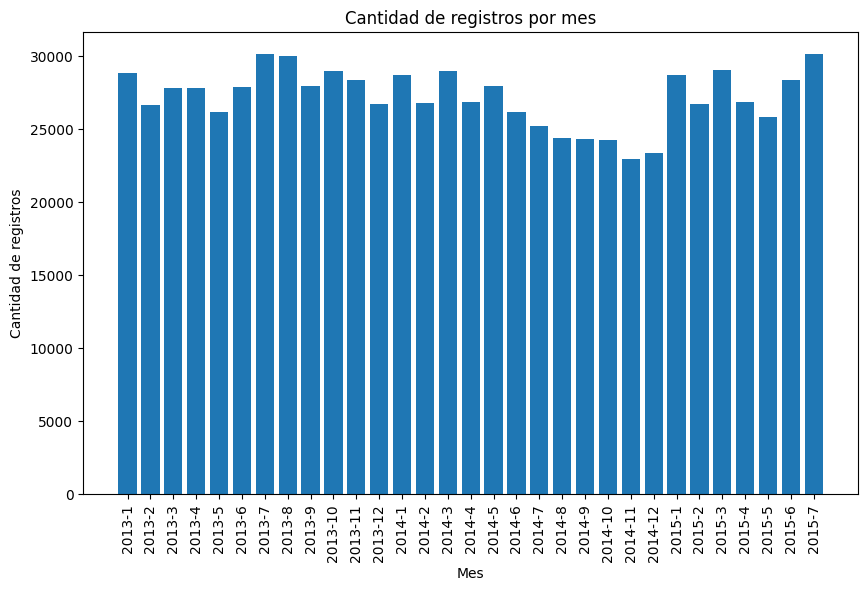

In [45]:
# Agrupar los datos
grouped_df = train_df.groupby(['Year', 'Month']).size().reset_index(name='Count')

# Crear una nueva columna para el eje x que combina el año y el mes
grouped_df['Year_Month'] = grouped_df['Year'].astype(str) + '-' + grouped_df['Month'].astype(str)

# Crear el gráfico de barras
plt.figure(figsize=(10,6))  # Ajusta el tamaño del gráfico según tus necesidades
plt.bar(grouped_df['Year_Month'], grouped_df['Count'])
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.title('Cantidad de registros por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de registros')
plt.show()

In [46]:
# Calcular el número total de registros
total_records = len(train_df)

# Calcular el número de registros que representan el 95%
cut_off = total_records * 0.95

# Ordenar el DataFrame por fecha
train_df_sorted = train_df.sort_values(by=['Year', 'Month', 'Day'])

# Encontrar la fecha de corte
cut_off_date = train_df_sorted.iloc[int(cut_off)][['Year', 'Month', 'Day']]

print("La fecha de corte es: ", cut_off_date)


La fecha de corte es:  Year     2015
Month       6
Day        18
Name: 48242, dtype: int64


In [47]:
# Ordena los valores para usar los últimos días como un conjunto de validación.
# Esto asegura que el conjunto de validación imite la estructura del conjunto de prueba en términos de la temporalidad.
temp = train_df.sort_values(["Year","Month","Day"], ignore_index=True).copy()

# Crea una columna 'Date' a partir de las columnas 'Year', 'Month' y 'Day'.
temp['Date'] = pd.to_datetime(temp[['Year', 'Month', 'Day']])

# Identifica la fecha de corte. Supongamos que la fecha de corte es el día 15 del mes 6 del año 2022.
cutoff_date = pd.Timestamp(year=2015, month=6, day=15)

# Encuentra el índice del primer registro que está en o después de la fecha de corte.
cutoff_index = temp[temp['Date'] >= cutoff_date].index[0]

print(f'El índice de la fecha de corte es: {cutoff_index}')

temp.drop('Date',inplace=True,axis=1)

El índice de la fecha de corte es: 797768


In [48]:
843579-797768

45811

In [49]:

# Selecciona el mismo período de tiempo que el conjunto de prueba
# Este es un enfoque común en el análisis de series de tiempo para asegurar que el modelo se valide en un período que refleje de cerca el período de tiempo del conjunto de prueba.
train = temp[:-45811].copy()       
vali = temp[-45811:].copy()

# Vuelve al mismo orden que el conjunto de datos original
# Ordenar por "Tienda" permite que los datos para una misma tienda estén juntos.
# Esto es útil si quieres examinar o modelar los datos de ventas para cada tienda por separado.
train.sort_values(["Store"], ignore_index=True, inplace=True)
vali.sort_values(["Store"], ignore_index=True, inplace=True)

# Luego, se ordenan los datos en orden descendente por "Año", "Mes" y "Día".
# Este ordenamiento puede ser útil para modelos de series de tiempo que asumen que las observaciones más recientes son más relevantes para predecir las observaciones futuras.
train.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)
vali.sort_values(["Year","Month","Day"], ascending=False ,ignore_index=True, inplace=True)

# Obtiene el objetivo (la variable que se va a predecir, en este caso 'Ventas').
# Se remueve la columna 'Sales' del conjunto de validación ya que es la variable que el modelo necesita predecir.
train_target = train['Sales'].copy()
train.drop('Sales',inplace=True,axis=1)

vali_target = vali['Sales'].copy()
vali.drop('Sales',inplace=True,axis=1)


In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb

In [54]:

# Define RMSPE score
def RMSPE_score(y_true, y_pred):
    return RMSPE(y_true, y_pred)

# Make scorer
RMSPE_scorer = make_scorer(RMSPE_score, greater_is_better=False)

## Ajuste del modelo XGBoost

In [55]:
model_xgb = xgb.XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)
# Parametros estimados que podrían funcionar

In [56]:
# Ajuste del modelo
model_xgb.fit(train, train_target)

train_rmspe = RMSPE(model_xgb.predict(train), train_target)
val_rmspe = RMSPE(model_xgb.predict(vali), vali_target)
    
print("Train RMSPE: {} and Validation RMSE: {}".format(train_rmspe,val_rmspe))

Train RMSPE: 0.05634200083244399 and Validation RMSE: 0.13109138838021164


In [ ]:
# Guardar modelo
import pickle
filename = 'xgboost.sav'
pickle.dump(model_xgb, open(filename, 'wb'))

#### Importancia de las variables

In [57]:
importance_df = pd.DataFrame({
    'feature': train.columns,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

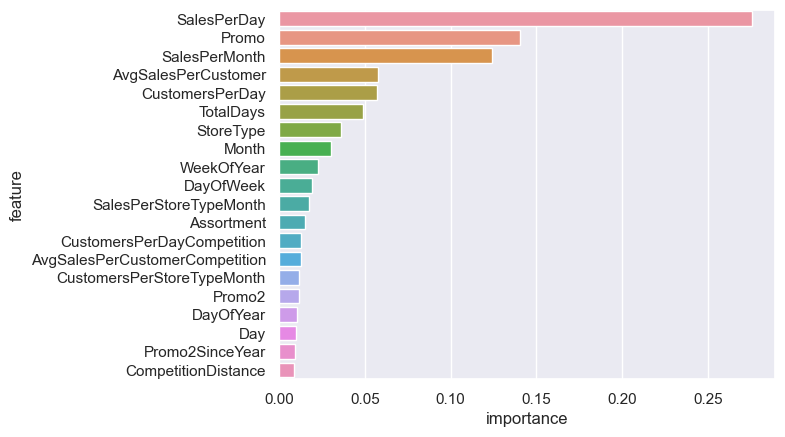

In [58]:
sns.set(font_scale = 1)
sns.barplot(data=importance_df.head(20), x='importance', y='feature');

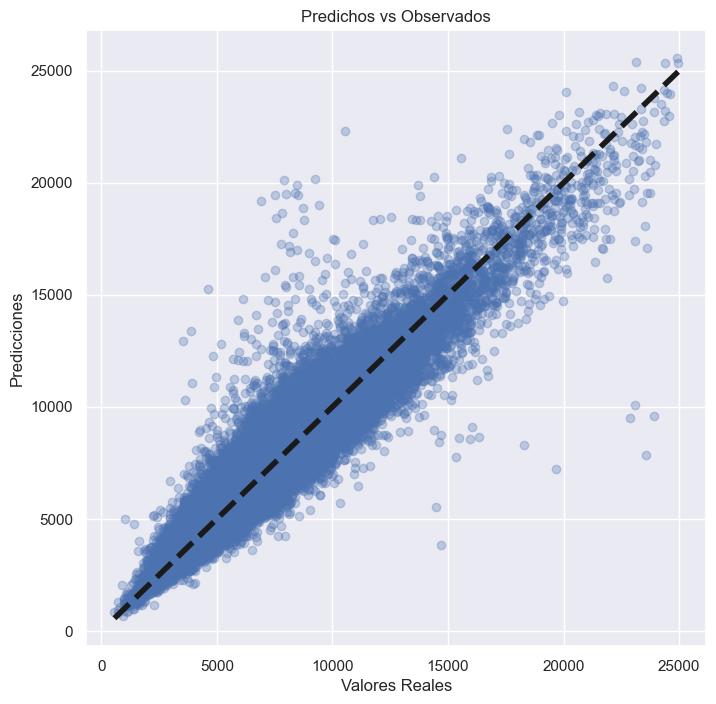

In [59]:
# Asume que ya tienes tus predicciones en una variable llamada 'y_pred'
# y los valores reales en una variable llamada 'y_real'
y_pred = model_xgb.predict(vali)
plt.figure(figsize=(8,8))
plt.scatter(vali_target, y_pred, alpha=0.3)
plt.plot([vali_target.min(), vali_target.max()], [vali_target.min(), vali_target.max()], 'k--', lw=4)
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predichos vs Observados')
plt.show()


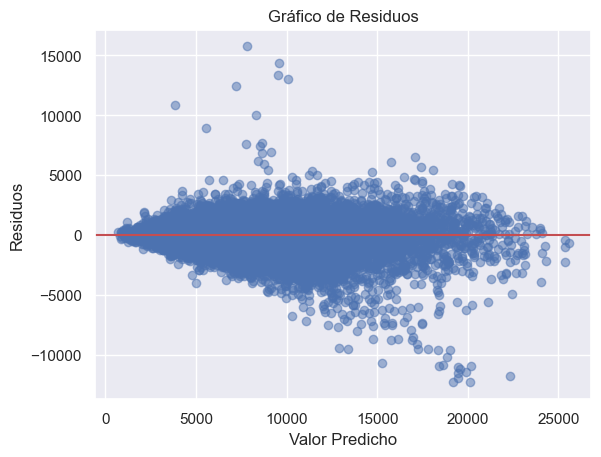

In [60]:
# Realizar las predicciones con el modelo
y_pred = model_xgb.predict(vali)

# Calcular los residuos
residuos = vali_target - y_pred

# Crear un gráfico de residuos
plt.scatter(y_pred, residuos, alpha=0.5)
plt.title('Gráfico de Residuos')
plt.xlabel('Valor Predicho')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='-') # Línea horizontal en el valor 0 de residuos
plt.show()

### Valores SHAP

In [ ]:
import shap

# Suponemos que X son nuestros datos de entrada
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(train)

shap.summary_plot(shap_values, train)


**Gráfico de resumen SHAP (summary_plot):** En este gráfico, cada punto en el gráfico representa la contribución de una característica a la predicción para una observación específica. Las características están en el eje Y y se ordenan por importancia, que se mide por la suma total de las magnitudes de las contribuciones SHAP para cada característica.
* Eje X: Representa el valor SHAP de una característica, que es la contribución de esa característica a la diferencia entre la predicción del modelo y la salida media del modelo (valor esperado). A la derecha del 0 en el eje x, los puntos representan valores positivos de SHAP que aumentan la predicción del modelo, mientras que a la izquierda del 0, los puntos representan valores negativos de SHAP que disminuyen la predicción del modelo.
* Color: El color de cada punto representa el valor de la característica para esa observación. Los colores más cálidos (como el rojo) indican valores más altos, y los colores más fríos (como el azul) indican valores más bajos.
* Posición vertical (Eje Y): Las características se ordenan en función de su importancia, que es la suma de las magnitudes de todas las contribuciones SHAP para cada característica. Las características más importantes están en la parte superior del gráfico.

In [134]:
# inicializa el explainer de SHAP con tu modelo XGBoost
explainer = shap.Explainer(model_xgb)

# calcula las contribuciones de Shapley para las predicciones
shap_values = explainer.shap_values(vali)

# visualiza las contribuciones de Shapley para la primera predicción
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], vali.iloc[0,:])


NameError: name 'shap' is not defined

**Gráfico de fuerza SHAP (force_plot):** Este gráfico representa visualmente las contribuciones de las características a una predicción individual.
* Eje X: Representa la contribución de cada característica a la predicción para una observación específica. El valor esperado se coloca en el inicio del eje x, y la salida del modelo para la observación específica se coloca al final del eje x. El camino de izquierda a derecha representa cómo el valor de la predicción cambia desde el valor esperado hasta la salida del modelo, con contribuciones de características individuales a lo largo del camino.
* Características: Cada característica que contribuye a la predicción se representa como una flecha que empuja la predicción hacia la izquierda (contribuciones negativas) o hacia la derecha (contribuciones positivas). Las flechas están coloreadas por el valor de la característica, con colores cálidos para valores altos y colores fríos para valores bajos.
* Longitud de las flechas: Representa la magnitud de la contribución de la característica, las flechas más largas tienen un mayor impacto en la predicción.

In [ ]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

# Puedes reemplazar esto con cualquier nombre de característica en tu conjunto de datos
caracteristica = 'SalesPerDay'

# Convierte el nombre de la característica a un índice
# Esto es necesario porque la función plot_partial_dependence espera un índice
feature_index = vali.columns.get_loc(caracteristica)

# Crear el gráfico de dependencia parcial
fig, ax = plt.subplots(figsize=(12, 6))
PartialDependenceDisplay.from_estimator(model_xgb, vali, [feature_index], ax=ax)
plt.show()


In [ ]:
# Se ajusta el modelo con la version de bajo nivel para poder obtener la
# contribucion de las distintas variables que de otro modo no estan disponibles
data =  xgb.DMatrix(train, label = train_target)
model = xgb.train({"learning_rate": 0.2, "max_depth": 10, 
                       "subsample": 0.9, "colsample_bytree": 0.7,
                      "n_estimators": 1000}, data)
model.predict(data, pred_contribs = True)


In [ ]:
# Para obtener las contribuciones de las características para una predicción
contributions = model.predict(data, pred_contribs=True)

# Esto te dará un array con la contribución de cada característica para cada predicción


In [ ]:
# Asumiendo que 'data' es un DataFrame pandas y 'contributions' es lo que obtuviste de model.predict
feature_names = train.columns
contributions_for_instance = contributions[0]  # contribuciones para el primer ejemplo
contributions_for_instance = contributions_for_instance[:-1]

# Crear un gráfico de barras
y_pos = np.arange(len(feature_names))
plt.barh(y_pos, contributions_for_instance, align='center')
plt.yticks(y_pos, feature_names)
plt.xlabel('Contribución a la predicción')
plt.title('Contribuciones de las características para el primer ejemplo')

plt.show()

Calcula las contribuciones de las características a las predicciones de un modelo de XGBoost. Cada contribución representa cómo una característica individual influye en la predicción de un ejemplo específico, en comparación con la predicción promedio para todos los ejemplos. Para cada ejemplo, la suma de todas las contribuciones de las características más la predicción promedio de todos los ejemplos da como resultado la predicción para ese ejemplo.

* Valores Positivos: Si una característica tiene una contribución positiva, significa que el valor de esa característica aumenta la predicción del modelo para esa observación. En otras palabras, el cambio en esa característica contribuye positivamente a la salida final del modelo. Por ejemplo, si estamos prediciendo precios de casas y la característica "tamaño" tiene una contribución positiva, significa que un tamaño mayor está asociado con un precio de casa más alto.
* Valores Negativos: Si una característica tiene una contribución negativa, significa que el valor de esa característica disminuye la predicción del modelo para esa observación. Esto significa que un cambio en esa característica contribuye negativamente a la salida final del modelo. Continuando con el ejemplo anterior, si la característica "distancia al centro de la ciudad" tiene una contribución negativa, significa que una mayor distancia al centro de la ciudad está asociada con un precio de casa más bajo.

In [ ]:
# Assumimos que model es tu modelo entrenado de xgboost

# Ganancia de información
xgb.plot_importance(model, importance_type='gain', title='Ganancia de Información')
plt.show()

# Cobertura
xgb.plot_importance(model, importance_type='cover', title='Cobertura')
plt.show()

Interpretación:

* gain: La importancia de cada característica se calcula como la reducción promedio en impureza, o "ganancia", que resulta de las divisiones en esa característica. Las características que son útiles para dividir los datos de manera efectiva tendrán una ganancia más alta.
* coverage: La cobertura de una característica se refiere al número promedio de observaciones afectadas por las divisiones en esa característica. Las características que afectan a un gran número de observaciones tendrán una cobertura más alta.

In [ ]:
from sklearn.inspection import permutation_importance

# Asegúrate de que el modelo esté entrenado y que x_val y y_val sean tu conjunto de validación
result = permutation_importance(model_xgb, vali, vali_target, n_repeats=10, random_state=42, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=vali.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()


La importancia de permutación es una técnica para determinar la importancia de las características en un modelo de machine learning. Funciona permutando los valores de cada característica y midiendo cómo disminuye el rendimiento del modelo. Si permutar los valores de una característica hace que el rendimiento del modelo disminuya mucho, eso indica que esa característica es importante.

## Ajuste de hiperparámetros

In [ ]:
# Definición de la grilla de parametros
# Define la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [2, 5, 10],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
    # Aquí puedes agregar más parámetros
}

In [ ]:
# Definición del modelo
# Define la configuración del modelo
model_tuning_xgb = xgb.XGBRegressor()

### Validación cruzada no anidada

#### Grid Search

In [ ]:
import pandas

In [ ]:
# Define la estrategia de validación cruzada
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Realizar Gird Search
gridsearchcv = GridSearchCV(model_tuning_xgb, param_grid, n_jobs=-1, 
                            scoring=RMSPE_scorer, cv=tscv, verbose = 1)
gridsearchcv.fit(train,train_target)

In [ ]:
# Best paramete set
print('Best parameters found:\n', gridsearchcv.best_params_)

# All results
print_all = True

if print_all:
    means = gridsearchcv.cv_results_['mean_test_score']
    stds = gridsearchcv.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gridsearchcv.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
best_model = XGBRegressor(
    **gridsearchcv.best_params_
)
best_model.fit(train,train_target)

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = best_model.predict(train)
pred_valid  = best_model.predict(vali)

print('Train RMSPE:', RMSPE(pred_train, train_target))
print('Valid RMSPE:', RMSPE(pred_valid, vali_target))

#### Random Search

In [ ]:
randomsearchcv = RandomizedSearchCV(model_tuning_xgb, param_grid, n_jobs=-1,
                                    scoring=RMSPE_scorer, cv=tscv, verbose = 1, 
                                    n_iter = 50, random_state = 1)
randomsearchcv.fit(train,train_target)

In [ ]:
# Best paramete set
print('Best parameters found:\n', randomsearchcv.best_params_)

# All results
print_all = False

if print_all:
    means = randomsearchcv.cv_results_['mean_test_score']
    stds = randomsearchcv.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, randomsearchcv.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
best_model = XGBRegressor(
    **randomsearchcv.best_params_
)
best_model.fit(train.drop('Sales',axis=1),train['Sales'])

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = best_model.predict(train)
pred_valid  = best_model.predict(vali)

print('Train RMSPE:', RMSPE(pred_train, train_target))
print('Test RMSPE:', RMSPE(pred_valid, vali_target))

### Validación cruzada anidada

### Random Search

In [ ]:
# Configuración de la validación cruzada anidada
cv_outer = TimeSeriesSplit(n_splits=3)
# Iterar por las divisiones del dataset original
rmspe_train_results = list() # Guardar el error de train
rmspe_valid_results = list() # Guardar el error de validation
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(train_search):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_valid_outer = train.iloc[train_ix, :], train.iloc[test_ix, :]
    y_train_outer, y_valid_outer = train_target[train_ix], train_target[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = TimeSeriesSplit(n_splits=3)

    # Definir la busqueda
    search = RandomizedSearchCV(model_tuning_xgb, param_grid, scoring=RMSPE_scorer, cv=cv_inner, n_iter = 50,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = best_model_iteration.predict(X_train_outer)
    pred_test  = best_model_iteration.predict(X_test_outer)
    # Calcular métricas de error
    train_rmspe_values = RMSPE(pred_train, y_train_outer)
    valid_rmspe_values = RMSPE(pred_test, y_valid_outer)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > rmspe_valid_results:
        best_model = result.best_estimator_
        best_score = rmspe_valid_results
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmspe_values)
    rmse_valid_results.append(valid_rmspe_values)
    # Reporte de progreso
    print('>RMSPE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, valid_rmspe_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSPE_train: %.3f (%.3f)' % (mean(rmspe_train_results), std(rmspe_train_results)))
print('RMSPE_test: %.3f (%.3f)' % (mean(rmspe_valid_results), std(rmspe_valid_results)))

In [ ]:
# Ajustar el modelo con todos los datos
best_model.fit(train, train_target)

In [ ]:
## Predicciones sobre conjunto de entrenamiento y validacion
pred_train = best_model.predict(train)
pred_test  = best_model.predict(vali)

print('Train RMSE:', RMSLE(pred_train, train_target))
print('Test RMSE:', RMSLE(pred_test, vali_target))

### Random Forest

In [136]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 500, 
                           max_depth = 30,
                           min_samples_split = 10,
                           min_samples_leaf = 9,
                           max_features = 0.8,
                           random_state = 42, 
                           n_jobs = -1)
# Train the model on training data
rf.fit(train, train_target)

RandomForestRegressor(max_depth=30, max_features=0.8, min_samples_leaf=9,
                      min_samples_split=10, n_estimators=500, n_jobs=-1,
                      random_state=42)

In [137]:
train_rmspe = RMSPE(rf.predict(train), train_target)
val_rmspe = RMSPE(rf.predict(vali), vali_target)
    
print("Train RMSPE: {} and Validation RMSE: {}".format(train_rmspe,val_rmspe))

Train RMSPE: 0.09213194609497986 and Validation RMSE: 0.13367932996340404


In [ ]:
# Definición de la grilla de parametros
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [25, 30, 35],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [7, 9, 11],
    'max_features': [0.7, 0.8, 0.9]
}


In [ ]:
# Definición del modelo
# Define la configuración del modelo
model_tuning_rf = RandomForestRegressor()

In [ ]:
# Configuración de la validación cruzada anidada
cv_outer = TimeSeriesSplit(n_splits=3)
# Iterar por las divisiones del dataset original
rmspe_train_results = list() # Guardar el error de train
rmspe_valid_results = list() # Guardar el error de validation
best_score = float("+inf") # Indicador para elegir el mejor ajuste

for train_ix, test_ix in cv_outer.split(train_search):
    # Comienzo del contador
    start = time.time()
    # Dividir los datos. El set de train se subdivide en una nueva muestra de train y test
    X_train_outer, X_valid_outer = train.iloc[train_ix, :], train.iloc[test_ix, :]
    y_train_outer, y_valid_outer = train_target[train_ix], train_target[test_ix]
    
    # Configuración de la validacion interna
    cv_inner = TimeSeriesSplit(n_splits=3)

    # Definir la busqueda
    search = RandomizedSearchCV(model_tuning_rf, param_grid, scoring=RMSPE_scorer, cv=cv_inner, n_iter = 50,
                                refit=True, verbose = 0, n_jobs = -1)
    # Ejecutar busqueda
    result = search.fit(X_train_outer, y_train_outer)
    # Seleccionar el mejor modelo para esa submuestra
    best_model_iteration = result.best_estimator_
    # Evaluar el modelo elegido con los datos de test de la submuestra
    pred_train = best_model_iteration.predict(X_train_outer)
    pred_test  = best_model_iteration.predict(X_test_outer)
    # Calcular métricas de error
    train_rmspe_values = RMSPE(pred_train, y_train_outer)
    valid_rmspe_values = RMSPE(pred_test, y_valid_outer)
    # Evaluar el modelo. Si la performance en test mejora, se selecciona
    if best_score > rmspe_valid_results:
        best_model = result.best_estimator_
        best_score = rmspe_valid_results
    # Guardar resultados del error en cada iteración
    rmse_train_results.append(train_rmspe_values)
    rmse_valid_results.append(valid_rmspe_values)
    # Reporte de progreso
    print('>RMSPE_train=%.3f, RMSE_test=%.3f score = %.3f, param = %s' % (train_rmse_values, valid_rmspe_values, result.best_score_, result.best_params_))
    
    # Finalizar contador
    stop = time.time()
    print("La iteración tomó", round(stop-start, 3), "segundos.")


# Resumen de la perfomance del modelo
print('RMSPE_train: %.3f (%.3f)' % (mean(rmspe_train_results), std(rmspe_train_results)))
print('RMSPE_test: %.3f (%.3f)' % (mean(rmspe_valid_results), std(rmspe_valid_results)))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(32, input_dim=30, activation='relu'))  # input_dim=30 porque tienes 30 columnas de entrada
model.add(Dense(16, activation='relu'))
model.add(Dense(1))  # 1 neurona de salida porque estás haciendo una regresión

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X, targets.ravel(), epochs=50, batch_size=10)

## Ajuste del modelo final

In [ ]:
X = train_df.drop('Sales',axis=1)
y = train_df['Sales']

In [55]:
model_xgb = xgb.XGBRegressor(n_jobs=-1, random_state=42,n_estimators=1000,   
                     learning_rate=0.2, max_depth=10, subsample=0.9, 
                     colsample_bytree=0.7)
# Parametros estimados que podrían funcionar

In [56]:
# Ajuste del modelo
model_xgb.fit(X, y)

predictions = model_xgb.predict(test_df)

Train RMSPE: 0.05634200083244399 and Validation RMSE: 0.13109138838021164


In [ ]:
submission = pd.DataFrame({"Id": ID ,"Sales": predictions.values})
submission.to_csv('submission.csv',index=False) 